<a href="https://colab.research.google.com/github/namigabbasov/Essentials-of-AI/blob/main/ACLED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> **ANALYSIS of ACLED DATA**
## <center> Namig Abbasov
## <center> May 11, 2025

## <center>**Question I: Exploratory Data Analysis**</center>

In this section, I conducted comprehensive exploratory data analysis of ACLED dataset sample. I focused on following steps.

---

### 1. **Data Loading and Structure Checking**
- Loaded dataset and previewed structure.
- Checked data types


---

### 2. **Data Quality Checking**
- No issues found with duplicated records or missing unique event IDs.
- Explored missing values across variables using visual tools (`missingno` and heatmaps).
- Found no critical issues. Most missingness is structural, not random:
  - For example, `actor2` is missing in many protests because they involve only one actor (e.g.protesters).
- Concluded that missing data do not pose significant limitations for analysis.

---

### 3. **Univariate Analysis**
- Checked distributions of key variables for skewness and imbalance.
    - For instance, found that `fatalities` is highly right-skewed with many zero values and few large outliers.
    - Serious transformation and proper modeling will be required if used in modeling.

---

### 4. **Bivariate & Multivariate Analysis**
- Explored relationships between various variables
  - for instance, mean fatalities were highest in Rebel group–Rebel group interactions, driven by few extreme cases
  - Rebel group–Identity militia had highest median fatalities as revealed in boxplots.
- Conducted country-level analysis:
  - for instance, Nigeria has highest total fatalities among all countries in dataset.
    
---

### 5. **Temporal Analysis**
- Tracked changes over time in both the number of events and fatalities.
- Identified spikes and drops across 2023 and 2024 with detailed event-date trends.

---

### 6. **Geospatial Analysis**
- Mapped all events using interactive Folium maps.
- Created animations to show how conflict intensity shifts across time and geography.

---


In [ ]:
### Set up timer
import time
start_time = time.time()

### Core Python and System Utilities
import os
import re
import random
import torch
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Data Manipulation
import pandas as pd
import numpy as np

### Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import folium
from folium import FeatureGroup, LayerControl, Map
from folium.plugins import MarkerCluster, HeatMap, TimestampedGeoJson


### Visualization defaults
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

### NLP Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### Feature Engineering for Text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize

### Modeling – Classical ML
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    BaggingClassifier, HistGradientBoostingClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import (
    train_test_split, GridSearchCV)
from sklearn.datasets import make_classification

### Modeling – Advanced ML
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb

### Evaluation Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, auc, precision_recall_curve, precision_recall_fscore_support,
    roc_auc_score)


### Hugging Face Transformers (NLP Modeling)
from datasets import Dataset
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    TrainingArguments, Trainer)

## <center>**Question I: Explanatory Data Analysis**

### 1. Load and Preview Data

In [ ]:
df= pd.read_csv("df_sample_ads.csv")
df.head()

event_id_cnty  event_date  year  time_precision           disorder_type  \
0      DRC30331  2023-08-01  2023               1          Demonstrations   
1      NIG32495  2023-08-01  2023               1      Political violence   
2       CAO7644  2023-08-02  2023               1      Political violence   
3      BFO10375  2023-08-03  2023               1      Political violence   
4      BFO10393  2023-08-04  2023               1  Strategic developments   

                   event_type                  sub_event_type  \
0                    Protests       Protest with intervention   
1  Violence against civilians  Abduction/forced disappearance   
2                     Battles                     Armed clash   
3  Explosions/Remote violence                Air/drone strike   
4      Strategic developments    Looting/property destruction   

                                              actor1  \
0          Protesters (Democratic Republic of Congo)   
1                 Katsina Communal Militia (Nigeria)   
2  Islamic State West Africa Province (ISWAP) and...   
3            Military Forces of Burkina Faso (2022-)   
4       JNIM: Group for Support of Islam and Muslims   

                                       assoc_actor_1            inter1  ...  \
0  EPLC: Awakening of Patriots for the Liberation...        Protesters  ...   
1                                                NaN  Identity militia  ...   
2                                                NaN       Rebel group  ...   
3                                                NaN      State forces  ...   
4                                                NaN       Rebel group  ...   

             location latitude longitude geo_precision  \
0  Goma - Les Volcans  -1.6954   29.2360             1   
1             Dandume  11.4588    7.1261             2   
2               Ganse  11.1543   14.0715             2   
3          Guitoaliga  12.7290    0.0199             2   
4                Sara  11.7205   -3.8370             1   

                      source         source_scale  \
0  Actualite; Mediacongo.net             National   
1         Guardian (Nigeria)             National   
2         Undisclosed Source  Local partner-Other   
3                   Facebook            New media   
4         Facebook; Whatsapp            New media   

                                               notes fatalities  \
0  On 1 August 2023, the Police scattered with te...          0   
1  On 1 August 2023, a Katsina militia abducted t...          0   
2  On 2 August 2023, the military forces clashed ...          0   
3  On 3 August 2023, the Burkina Faso air force c...          3   
4  Looting: On 4 August 2023, presumed JNIM milit...          0   

                   tags   timestamp  
0  crowd size=no report  1738629517  
1                   NaN  1736845181  
2                   NaN  1730158783  
3                   NaN  1691427731  
4                   NaN  1691427731  

[5 rows x 31 columns]

In [ ]:
df.tail()

event_id_cnty  event_date  year  time_precision           disorder_type  \
995       BEN1491  2024-08-01  2024               1      Political violence   
996      NIG37932  2024-08-01  2024               1          Demonstrations   
997      NIG37994  2024-08-01  2024               1  Strategic developments   
998      BFO12384  2024-08-01  2024               1  Strategic developments   
999      NIG37921  2024-08-01  2024               1          Demonstrations   

                 event_type                sub_event_type  \
995                   Riots                  Mob violence   
996                   Riots         Violent demonstration   
997  Strategic developments      Change to group/activity   
998  Strategic developments  Looting/property destruction   
999                   Riots         Violent demonstration   

                                  actor1            assoc_actor_1  \
995                      Rioters (Benin)  Vigilante Group (Benin)   
996                    Rioters (Nigeria)                      NaN   
997        Government of Nigeria (2023-)                      NaN   
998  Islamic State Sahel Province (ISSP)                      NaN   
999                    Rioters (Nigeria)                      NaN   

           inter1  ... location latitude longitude geo_precision  \
995       Rioters  ...     Bopa   6.5900    1.9700             1   
996       Rioters  ...    Daura  13.0359    8.3163             1   
997  State forces  ...     Karu   9.0469    7.7636             3   
998   Rebel group  ...     Dori  14.0400   -0.0300             2   
999       Rioters  ...   Suleja   9.1758    7.1808             1   

                                          source         source_scale  \
995                Benin Web TV; L'investigateur             National   
996  Daily Post (Nigeria); Daily Trust (Nigeria)             National   
997                         Daily Post (Nigeria)             National   
998                           Undisclosed Source  Local partner-Other   
999  Daily Post (Nigeria); Daily Trust (Nigeria)             National   

                                                 notes fatalities  \
995  On 1 August 2024, a mob armed with sticks and ...          0   
996  On 1 August 2024, residents demonstrated in Da...          0   
997  Security measures: On 1 August 2024, the Karu ...          0   
998  Looting: On 1 August 2024, IS Sahel militants ...          0   
999  On 1 August 2024, residents erected barricades...          4   

                     tags   timestamp  
995  crowd size=no report  1737435504  
996  crowd size=no report  1744679474  
997                   NaN  1723505942  
998                   NaN  1730158766  
999  crowd size=no report  1730180193  

[5 rows x 31 columns]

In [ ]:
df.sample(3)

event_id_cnty  event_date  year  time_precision       disorder_type  \
430      NIG34439  2024-01-11  2024               1  Political violence   
691      NIG36072  2024-04-17  2024               1      Demonstrations   
865      NIG37283  2024-06-12  2024               1      Demonstrations   

                     event_type                  sub_event_type  \
430  Violence against civilians  Abduction/forced disappearance   
691                    Protests                Peaceful protest   
865                    Protests                Peaceful protest   

                                 actor1  \
430  Unidentified Armed Group (Nigeria)   
691                Protesters (Nigeria)   
865                Protesters (Nigeria)   

                                         assoc_actor_1             inter1  \
430                                                NaN  Political militia   
691                                  Farmers (Nigeria)         Protesters   
865  JAF: Joint Action Front; Take it Back Movement...         Protesters   

     ... location latitude longitude geo_precision  \
430  ...    Bwari   9.2833    7.3833             2   
691  ...   Alausa   6.6096    3.3566             1   
865  ...    Ikeja   6.5942    3.3375             1   

                                                source       source_scale  \
430        Daily Post (Nigeria); Daily Trust (Nigeria)           National   
691     New Telegraph; Sahara Reporters; Sun (Nigeria)  National-Regional   
865  Blueprint; Daily Post (Nigeria); Daily Trust (...           National   

                                                 notes fatalities  \
430  On 11 January 2024, an unidentified armed grou...          0   
691  On 17 April 2024, a group of corporate farmers...          0   
865  On 12 June 2024, protesters from the Take it B...          0   

                     tags   timestamp  
430  local administrators  1736845181  
691  crowd size=no report  1713830568  
865  crowd size=no report  1719274229  

[3 rows x 31 columns]

In [ ]:
df.columns

Index(['event_id_cnty', 'event_date', 'year', 'time_precision',
       'disorder_type', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'civilian_targeting', 'iso', 'region', 'country',
       'admin1', 'admin2', 'admin3', 'location', 'latitude', 'longitude',
       'geo_precision', 'source', 'source_scale', 'notes', 'fatalities',
       'tags', 'timestamp'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   event_id_cnty       1000 non-null   object 
 1   event_date          1000 non-null   object 
 2   year                1000 non-null   int64  
 3   time_precision      1000 non-null   int64  
 4   disorder_type       1000 non-null   object 
 5   event_type          1000 non-null   object 
 6   sub_event_type      1000 non-null   object 
 7   actor1              1000 non-null   object 
 8   assoc_actor_1       263 non-null    object 
 9   inter1              1000 non-null   object 
 10  actor2              831 non-null    object 
 11  assoc_actor_2       259 non-null    object 
 12  inter2              831 non-null    object 
 13  interaction         1000 non-null   object 
 14  civilian_targeting  354 non-null    object 
 15  iso                 1000 non-null   int64  
 16  region 

In [ ]:
df.shape

(1000, 31)

In [ ]:
selected_cols = [
    'year', 'disorder_type', 'event_type', 'sub_event_type', 'actor1',
    'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
    'interaction', 'civilian_targeting', 'region', 'country',
    'admin1', 'admin2', 'admin3', 'location',
    'source', 'source_scale', 'tags']

for col in selected_cols:
    print(f"\n\033[1mValue Counts for: {col}\033[0m")
    print(df[col].value_counts(dropna=False))


Value Counts for: year
year
2024    606
2023    394
Name: count, dtype: int64

Value Counts for: disorder_type
disorder_type
Political violence                    686
Strategic developments                181
Demonstrations                        131
Political violence; Demonstrations      2
Name: count, dtype: int64

Value Counts for: event_type
event_type
Violence against civilians    310
Battles                       254
Strategic developments        181
Protests                      118
Explosions/Remote violence     70
Riots                          67
Name: count, dtype: int64

Value Counts for: sub_event_type
sub_event_type
Armed clash                            246
Attack                                 214
Peaceful protest                       108
Abduction/forced disappearance          93
Looting/property destruction            91
Mob violence                            52
Other                                   32
Remote explosive/landmine/IED           28
Air/drone strike

### 2. Check Data Quality
Once I learned about how data looks like, next I move to have deep exploration of data quality. I explore the following questions:
- Are there any obvious missing/duplicate values?
- Are numeric columns correctly classified?
- Should any columns be converted (e.g., date strings to datetime)?
- Do the first/last rows show consistency?
- Are there any suspicious values (e.g., "NULL", 9999 placeholder)?

In [ ]:
### are there any duplicates?
duplicates = df[df.duplicated(keep=False)]
print(f"Number of exact duplicates: {len(duplicates)}")

Number of exact duplicates: 0


In [ ]:
### is each row unique event?
df['event_id_cnty'].nunique() == len(df)

True

In [ ]:
### which variables have how many missing obs?
df.isnull().sum().sort_values(ascending=False)

tags                  797
assoc_actor_2         741
assoc_actor_1         737
civilian_targeting    646
admin3                362
inter2                169
actor2                169
admin2                  6
admin1                  1
location                0
latitude                0
event_id_cnty           0
geo_precision           0
source                  0
source_scale            0
notes                   0
fatalities              0
longitude               0
iso                     0
country                 0
region                  0
event_date              0
interaction             0
inter1                  0
actor1                  0
sub_event_type          0
event_type              0
disorder_type           0
time_precision          0
year                    0
timestamp               0
dtype: int64

In [ ]:
### what propotion is missing from each column
df.isnull().mean().sort_values(ascending=False)

tags                  0.797
assoc_actor_2         0.741
assoc_actor_1         0.737
civilian_targeting    0.646
admin3                0.362
inter2                0.169
actor2                0.169
admin2                0.006
admin1                0.001
location              0.000
latitude              0.000
event_id_cnty         0.000
geo_precision         0.000
source                0.000
source_scale          0.000
notes                 0.000
fatalities            0.000
longitude             0.000
iso                   0.000
country               0.000
region                0.000
event_date            0.000
interaction           0.000
inter1                0.000
actor1                0.000
sub_event_type        0.000
event_type            0.000
disorder_type         0.000
time_precision        0.000
year                  0.000
timestamp             0.000
dtype: float64

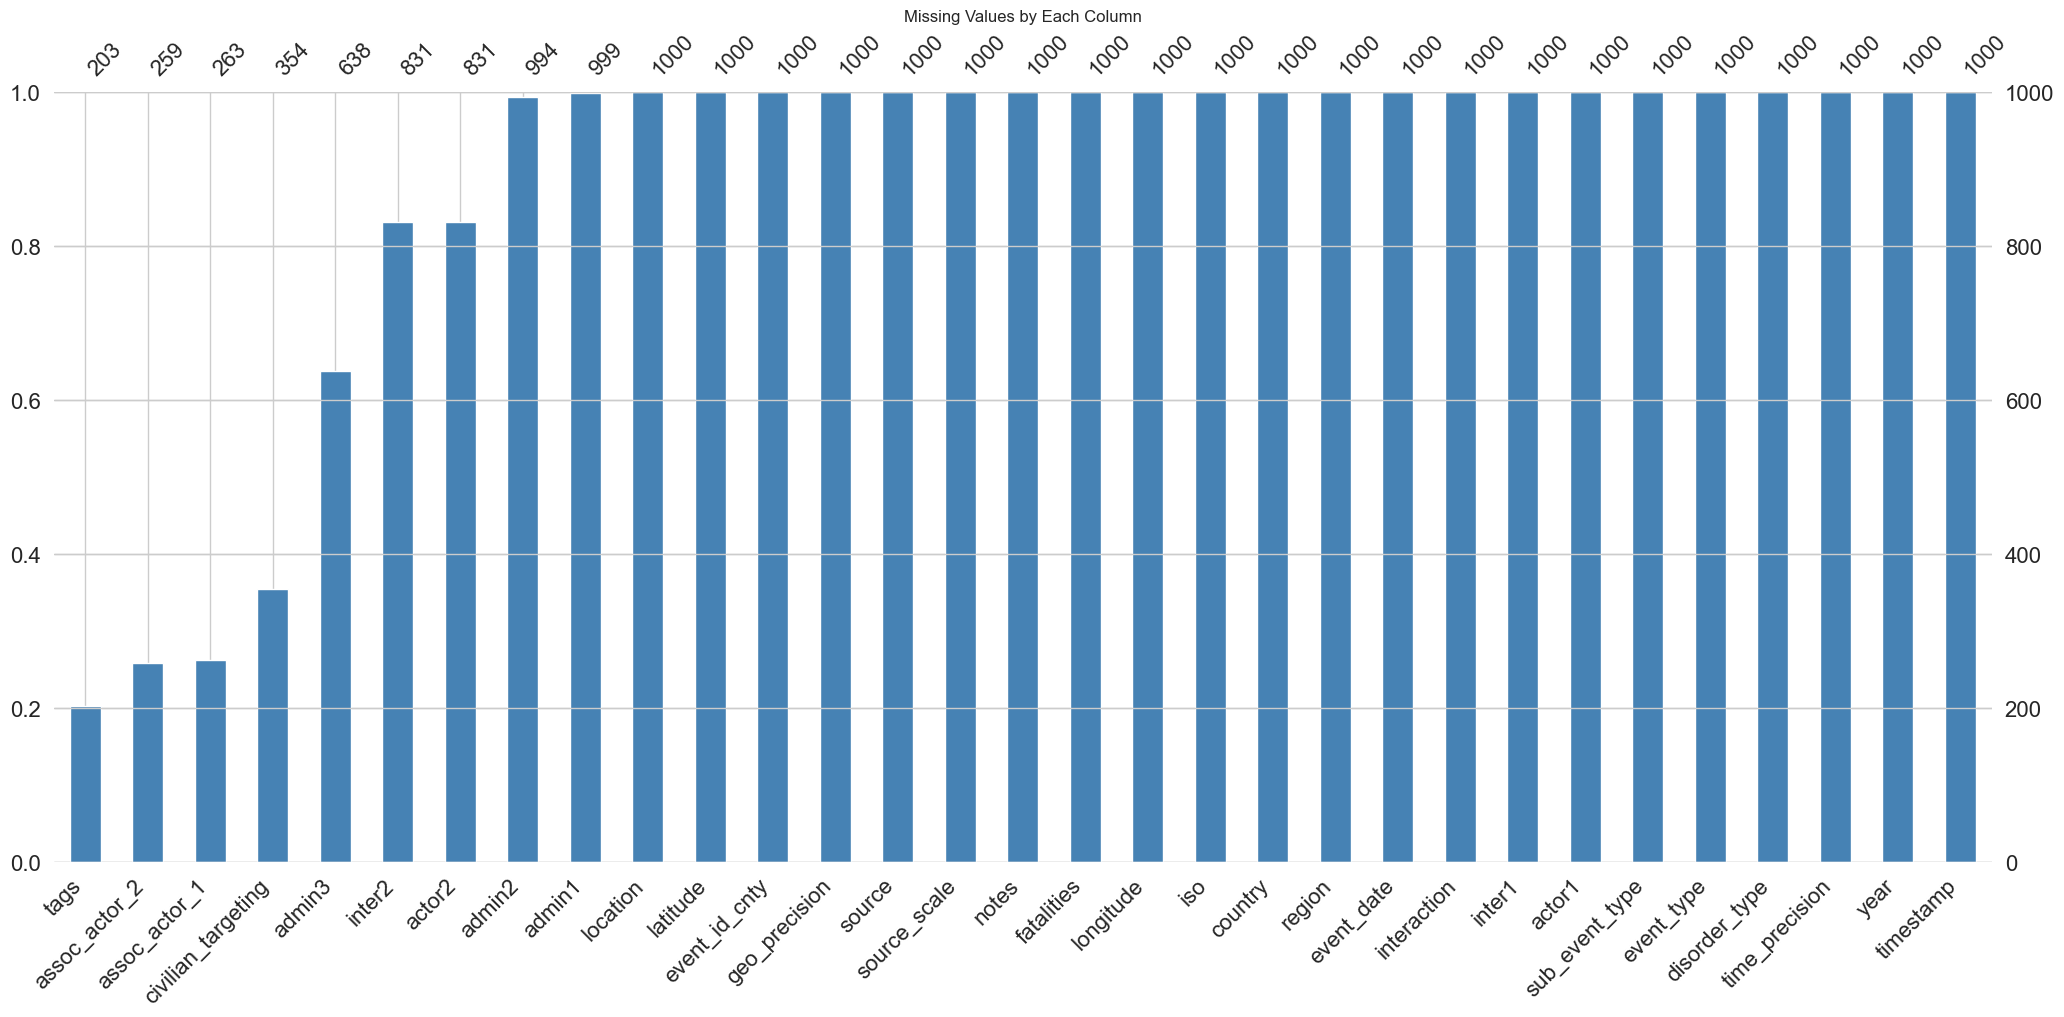

In [ ]:
### visual illustration of number missing obs in each column

missing_order = df.isnull().mean().sort_values(ascending=False)
df_ordered = df[missing_order.index]
msno.bar(df_ordered, color="steelblue")
plt.title("Missing Values by Each Column")
plt.show()

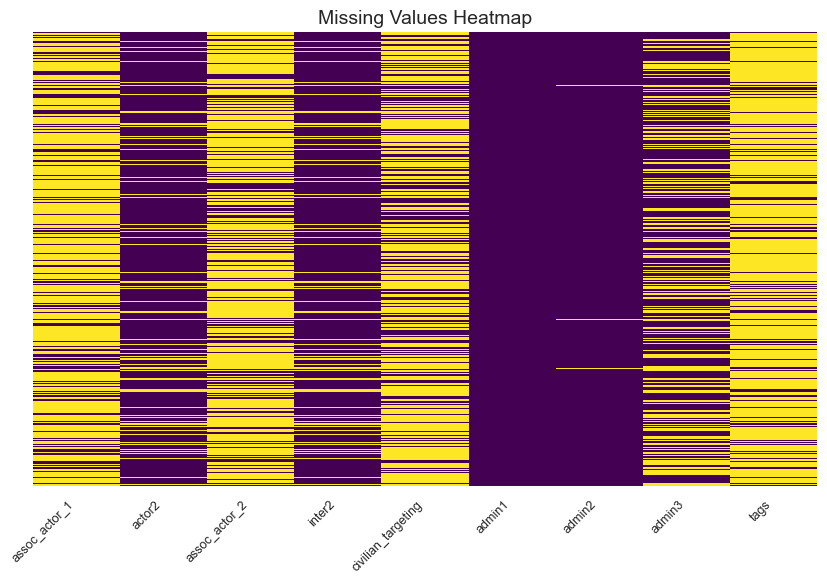

In [ ]:
### are there patterns in distribution of missing data across columns

### for instance, patterns shows if no Actor 2, then no assoc_actor_2.
### this example is obvious by definition, but overall good to shows cluster of NAs across dataset.

missing = df.isnull().sum()
missing_cols = missing[missing > 0].index
df_missing = df[missing_cols]
plt.figure(figsize=(len(missing_cols)*0.5 + 4, 6))
sns.heatmap(df_missing.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks([])
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Proportion of Missing Second Actor by Event Type')

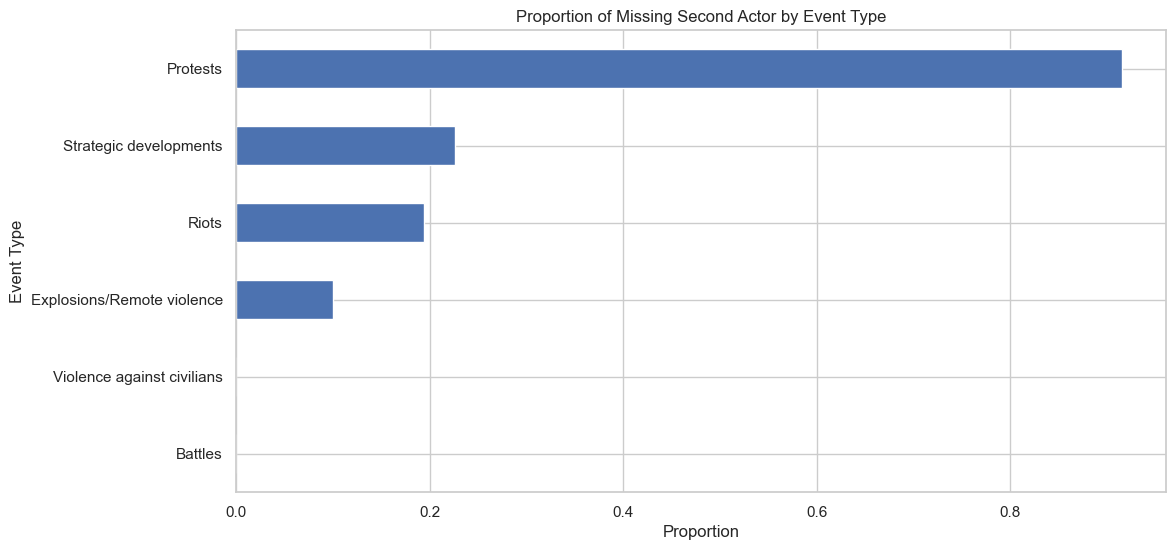

In [ ]:
### next, I check if missingness in one variable is connected to another variable by proportion

### for example, most protests might not have actor2.
### In battles and violence against civilians, there should be actor2.

df['missing_actor2'] = df['actor2'].isnull().astype(int)
df.groupby('event_type')['missing_actor2'].mean().sort_values().plot(kind='barh')
plt.ylabel("Event Type")
plt.xlabel("Proportion")
plt.title("Proportion of Missing Second Actor by Event Type")

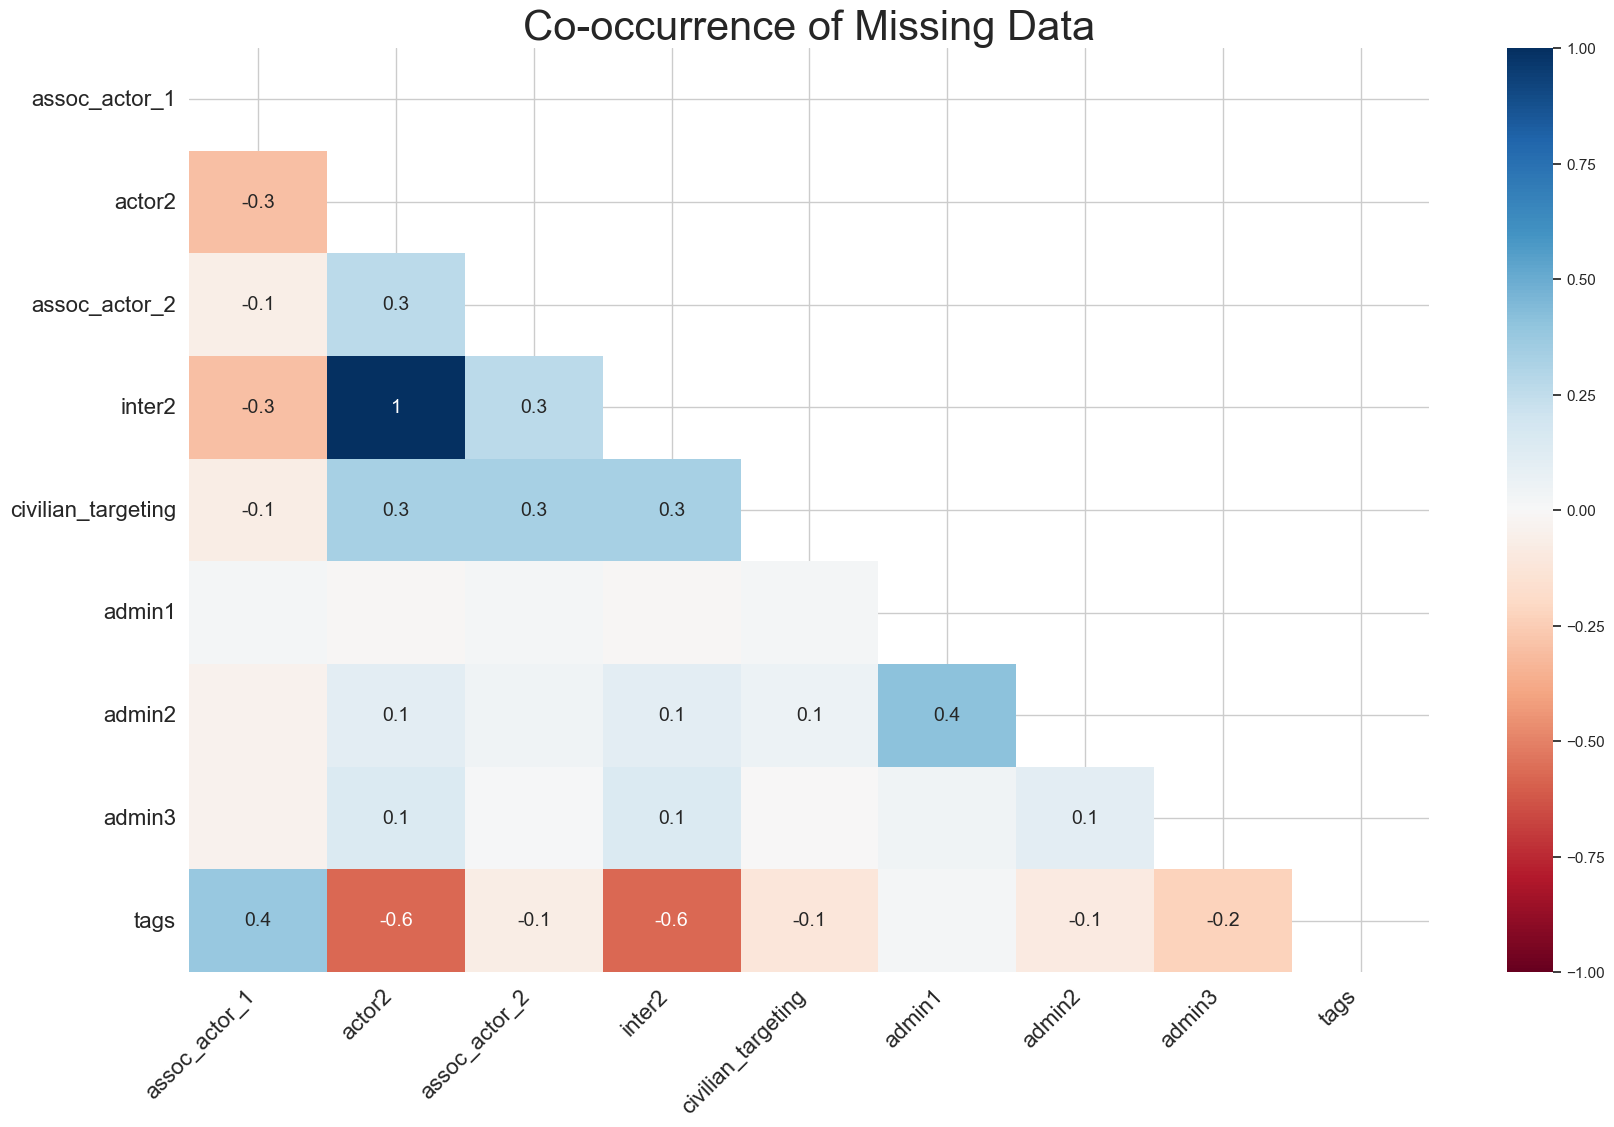

In [ ]:
### Checking Missingness Correlation

### events with actor2 are observationally less likely to be assigned tags.
### probably because events such as protests(croud size), which don't have actor2, always have tags.


msno.heatmap(df)
plt.title("Co-occurrence of Missing Data", size=30)
plt.show()

In [ ]:
### Let's check exact number: only 48 intersect
a_missing = df['tags'].isnull()
b_missing = df['actor2'].isnull()
print("Tags missing:", a_missing.sum())
print("Actor 2 missing:", b_missing.sum())
print("Both missing:", (a_missing & b_missing).sum())

Tags missing: 797
Actor 2 missing: 169
Both missing: 48


Text(0.5, 1.0, "Missing 'tags' by Event Type")

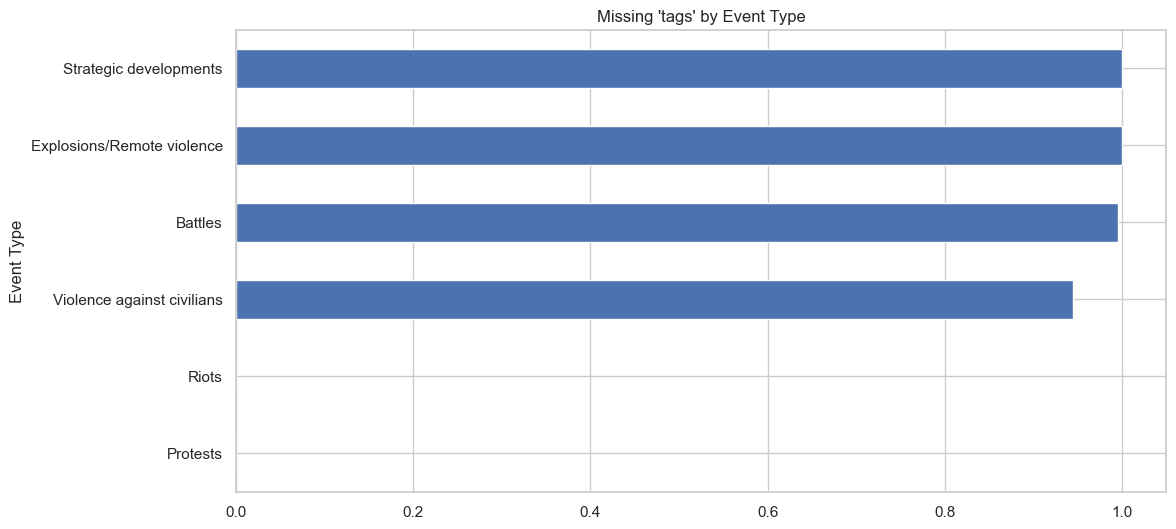

In [ ]:
### Now checkng which events have full tags
df['tags_missing'] = df['tags'].isnull()
df.groupby('event_type')['tags_missing'].mean().sort_values().plot(kind='barh')
plt.ylabel("Event Type")
plt.title("Missing 'tags' by Event Type")

### 3. Univariate Analysis

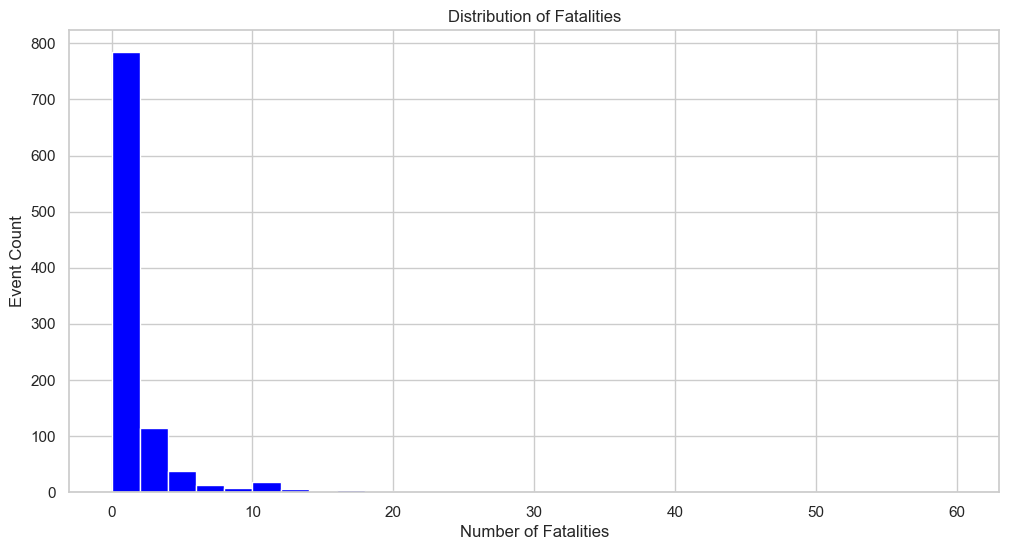

fatalities
0     633
1     151
3      57
2      57
4      23
10     17
5      15
6       8
7       5
8       5
12      4
9       3
20      3
13      2
11      2
17      2
16      2
19      2
23      2
34      2
Name: count, dtype: int64

In [ ]:
### most of events have 0 fatalities - Highly skewed
df['fatalities'].hist(bins=30, color='blue')
plt.title("Distribution of Fatalities")
plt.xlabel("Number of Fatalities")
plt.ylabel("Event Count")
plt.show()

df['fatalities'].value_counts().nlargest(20) ### 633 events has 0 fatalities.

In [ ]:
### I identify  outliers below: 159 rows are outliers in fatalities column.


Q1 = df['fatalities'].quantile(0.25)
Q3 = df['fatalities'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR ### outlier thresholds
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = df[(df['fatalities'] < lower_bound) | (df['fatalities'] > upper_bound)]
print(f"IQR Outliers: {len(outliers_iqr)} rows")

IQR Outliers: 159 rows


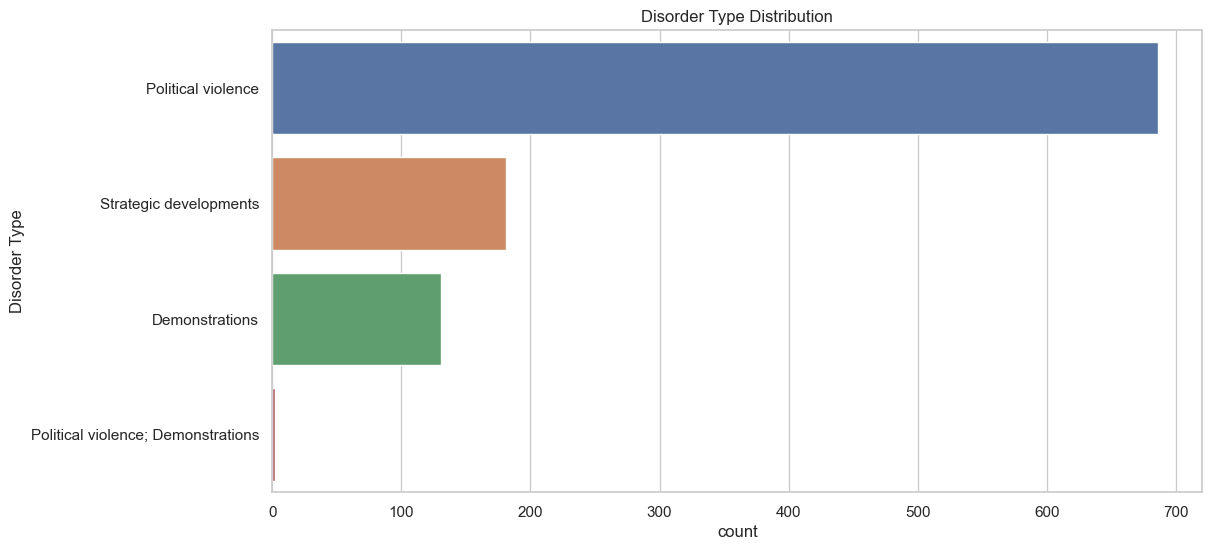

disorder_type
Political violence                    686
Strategic developments                181
Demonstrations                        131
Political violence; Demonstrations      2
Name: count, dtype: int64

In [ ]:
### disorder type - heavily imbalanced - most are political violence
### will need balancing techniques when modeling
sns.countplot(y='disorder_type', data=df, order=df['disorder_type'].value_counts().index)
plt.ylabel("Disorder Type")
plt.title("Disorder Type Distribution")
plt.show()

df['disorder_type'].value_counts()

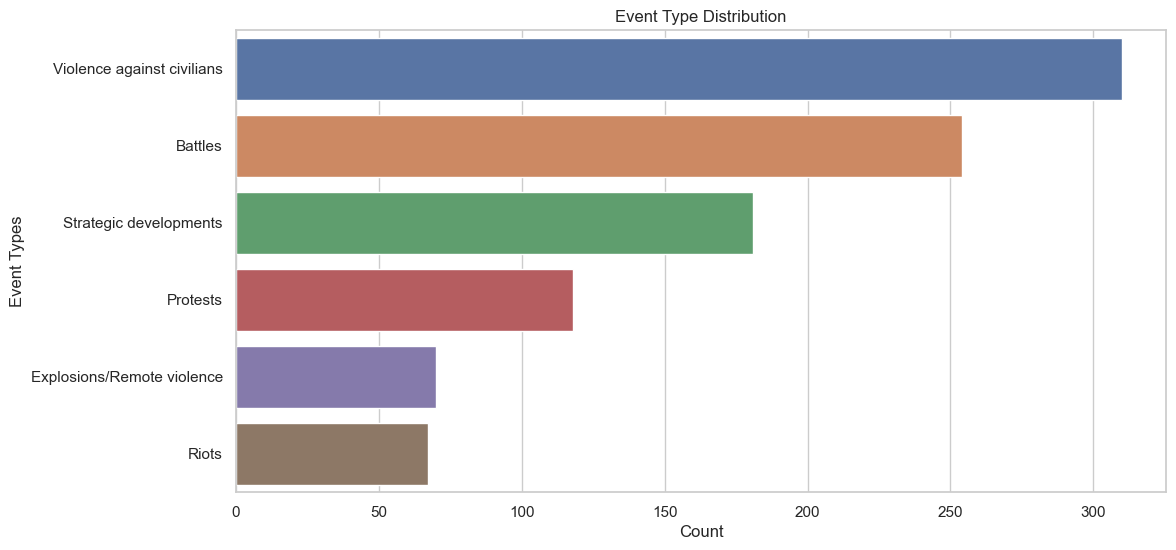

In [ ]:
### event type - less imbalanced

sns.countplot(y='event_type', data=df, order=df['event_type'].value_counts().index)
plt.title("Event Type Distribution")
plt.ylabel("Event Types")
plt.xlabel("Count")
plt.show()

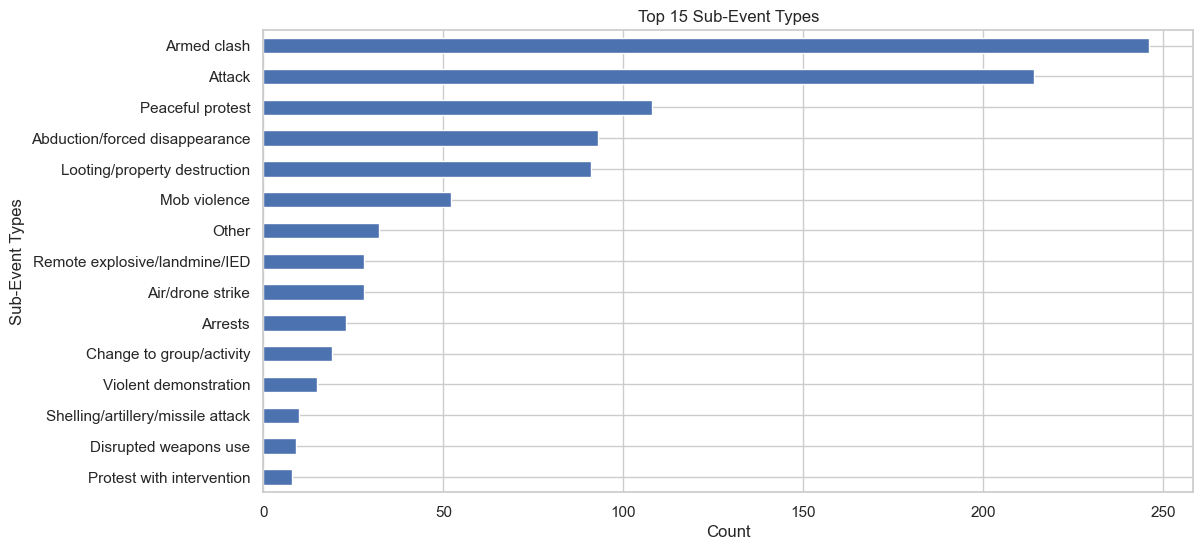

In [ ]:
### Sub Event Type

df['sub_event_type'].value_counts().nlargest(15).plot(kind='barh')
plt.ylabel("Sub-Event Types")
plt.title("Top 15 Sub-Event Types")
plt.xlabel("Count")
plt.gca().invert_yaxis()
plt.show()

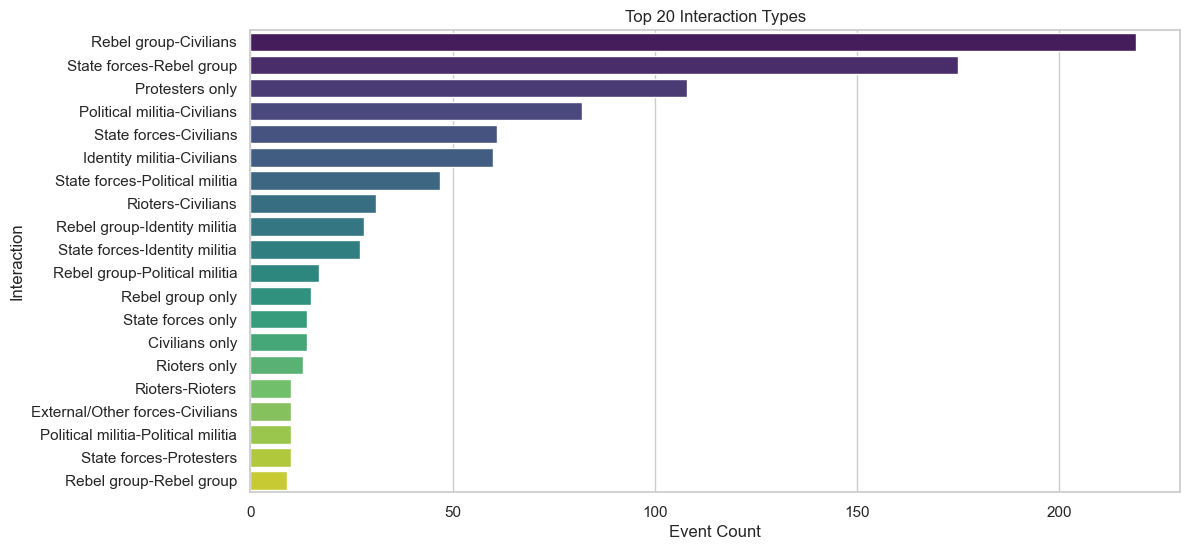

In [ ]:
### Interaction frequencies
top_interactions = df['interaction'].value_counts().nlargest(20)
sns.barplot(x=top_interactions.values, y=top_interactions.index, palette='viridis')
plt.title("Top 20 Interaction Types")
plt.xlabel("Event Count")
plt.ylabel("Interaction")
plt.show()

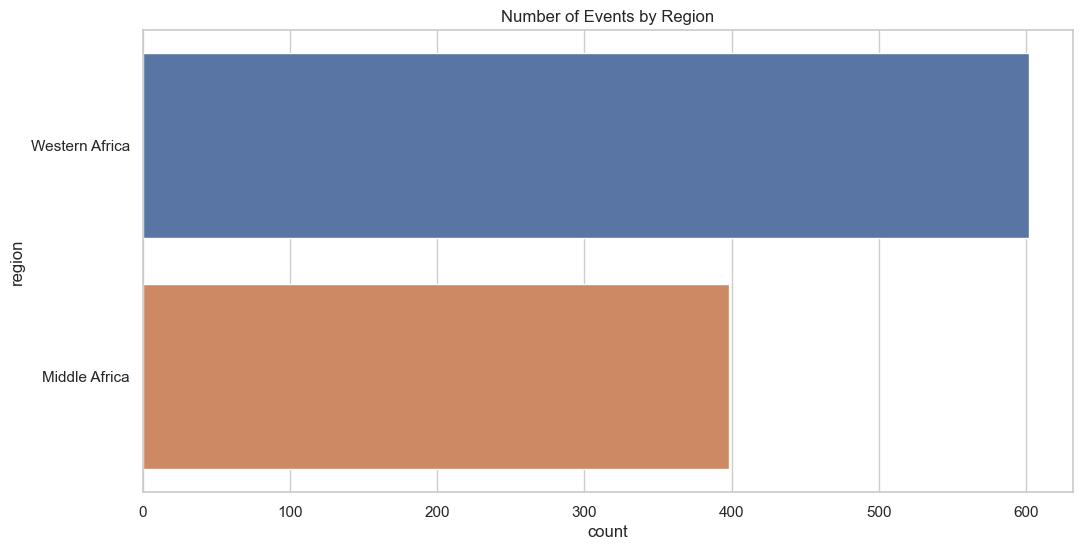

In [ ]:
sns.countplot(y='region', data=df, order=df['region'].value_counts().index)
plt.title("Number of Events by Region")
plt.show()

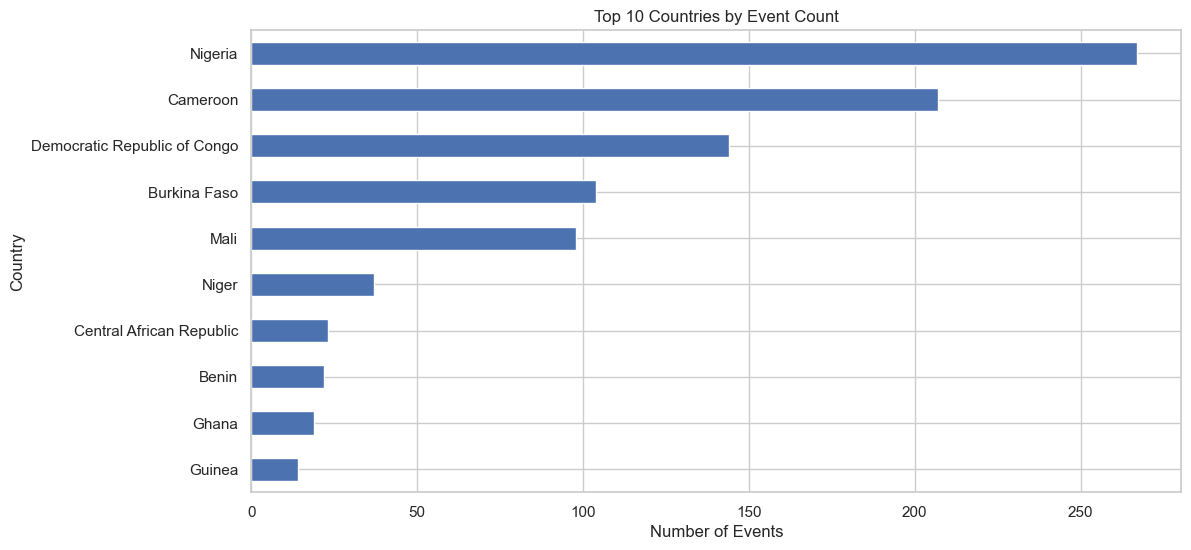

In [ ]:
### countries with highest number of events

df['country'].value_counts().nlargest(10).plot(kind='barh')
plt.title("Top 10 Countries by Event Count")
plt.xlabel("Number of Events")
plt.ylabel("Country")
plt.gca().invert_yaxis()
plt.show()

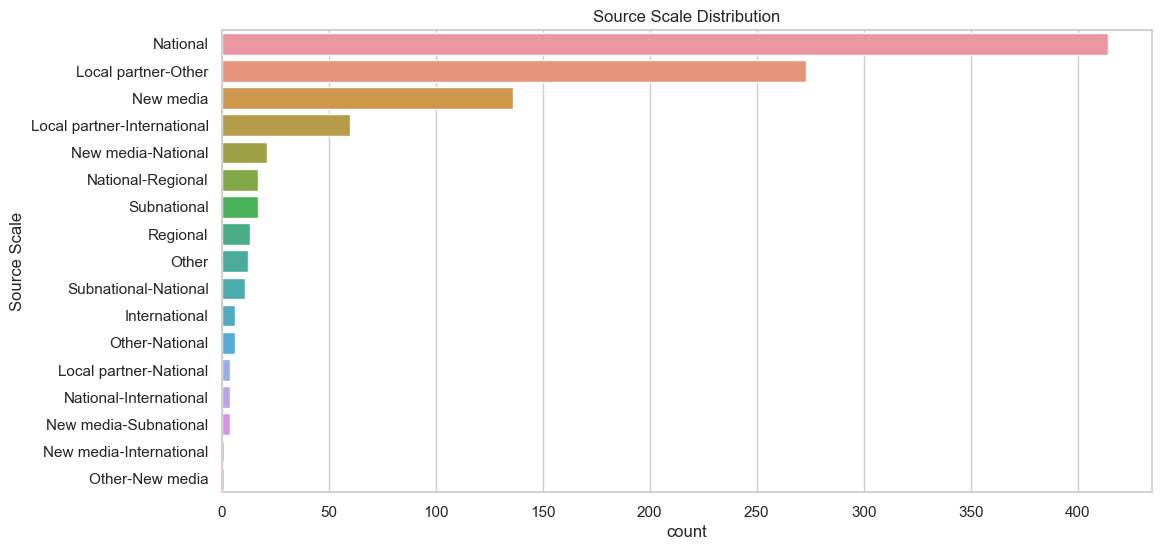

In [ ]:
### Source Scale - Most sources are national level
sns.countplot(y='source_scale', data=df, order=df['source_scale'].value_counts().index)
plt.title("Source Scale Distribution")
plt.ylabel("Source Scale")
plt.show()

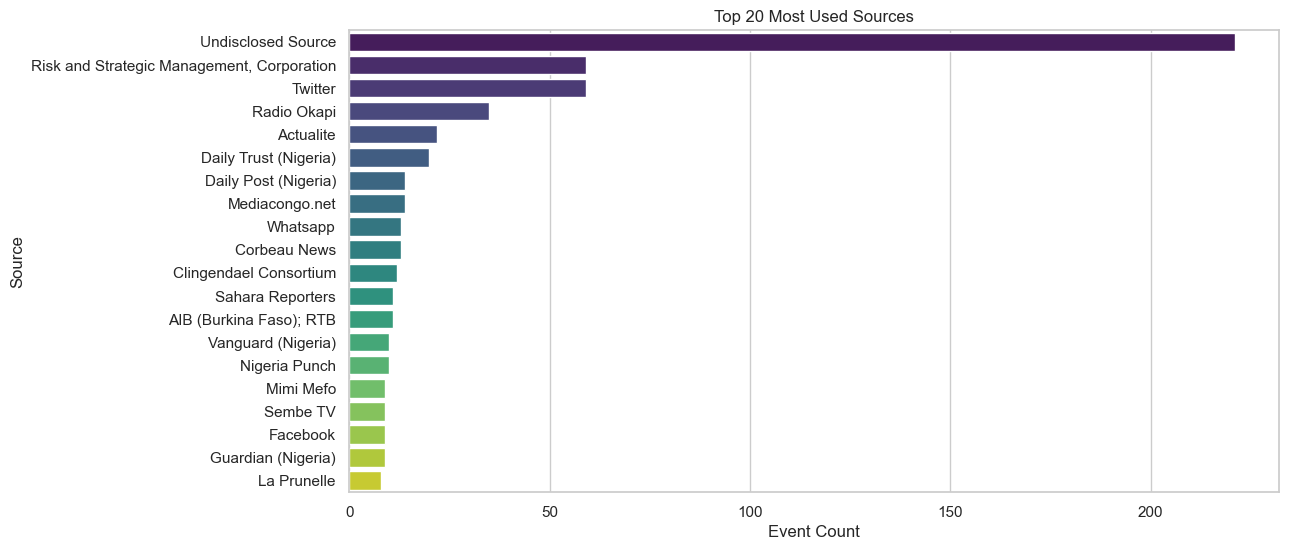

In [ ]:
### most common sources
top_sources = df['source'].value_counts().nlargest(20)
sns.barplot(y=top_sources.index, x=top_sources.values, palette='viridis')
plt.title("Top 20 Most Used Sources")
plt.xlabel("Event Count")
plt.ylabel("Source")
plt.show()

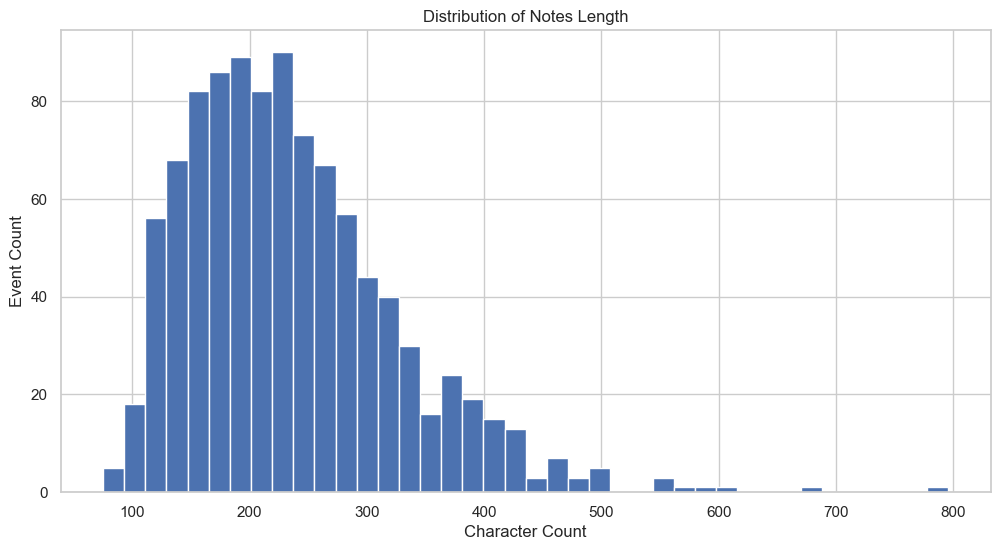

In [ ]:
### Distribution of Notes Length

### most notes are around 200 characters long with few longer notes - right-skewed distribution
### important consideration when applying NLP models that require padding or truncating input sequences

df['notes_length'] = df['notes'].str.len()
df['notes_length'].hist(bins=40)
plt.title("Distribution of Notes Length")
plt.xlabel("Character Count")
plt.ylabel("Event Count")
plt.show()

### 4. Bivariate and Multivariate Analysis

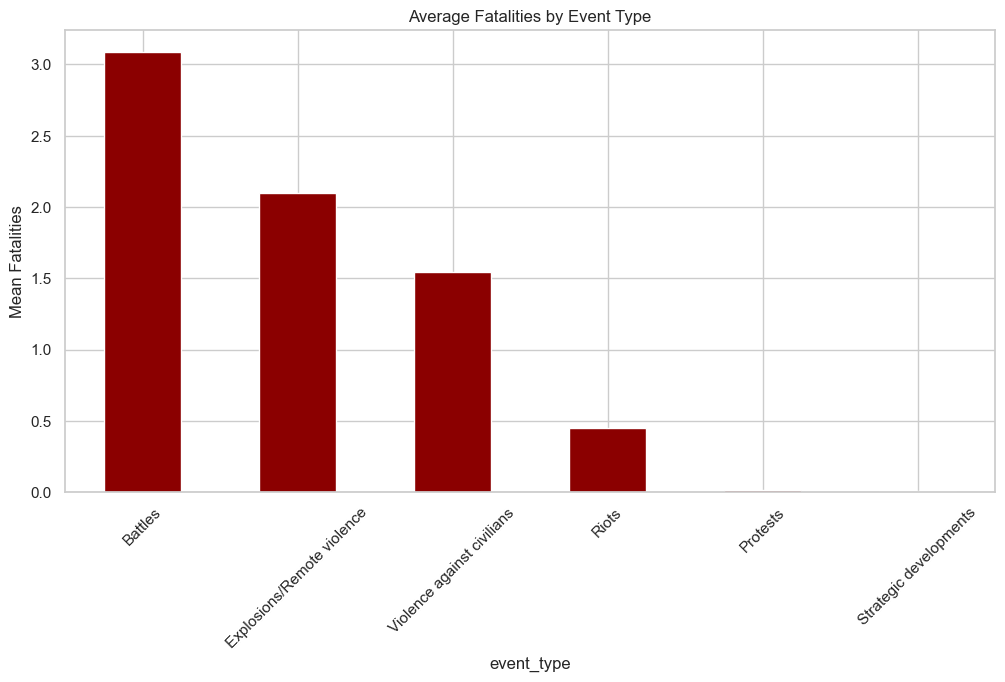

In [ ]:
### Average Fatalities by Event Type - Battles result with most fatalities
fatal_by_type = df.groupby('event_type')['fatalities'].mean().sort_values(ascending=False)
fatal_by_type.plot(kind='bar', color='darkred')
plt.title("Average Fatalities by Event Type")
plt.ylabel("Mean Fatalities")
plt.xticks(rotation=45)
plt.show()

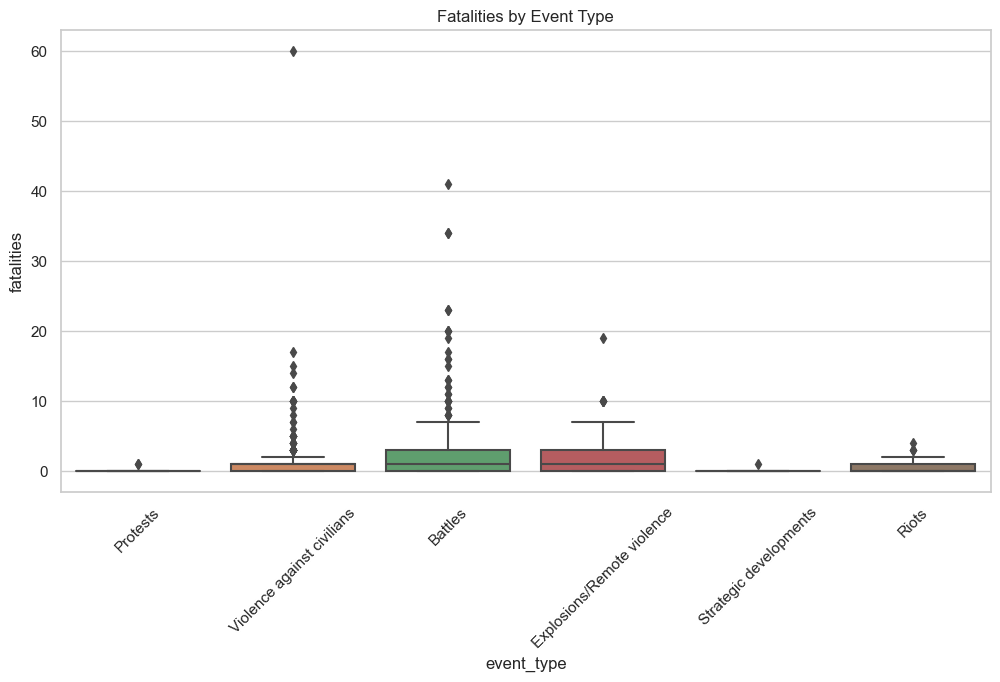

In [ ]:
### Distribution of Fatalities by Event Type - again battles are most lethal
sns.boxplot(x='event_type', y='fatalities', data=df)
plt.title("Fatalities by Event Type")
plt.xticks(rotation=45)
plt.show()

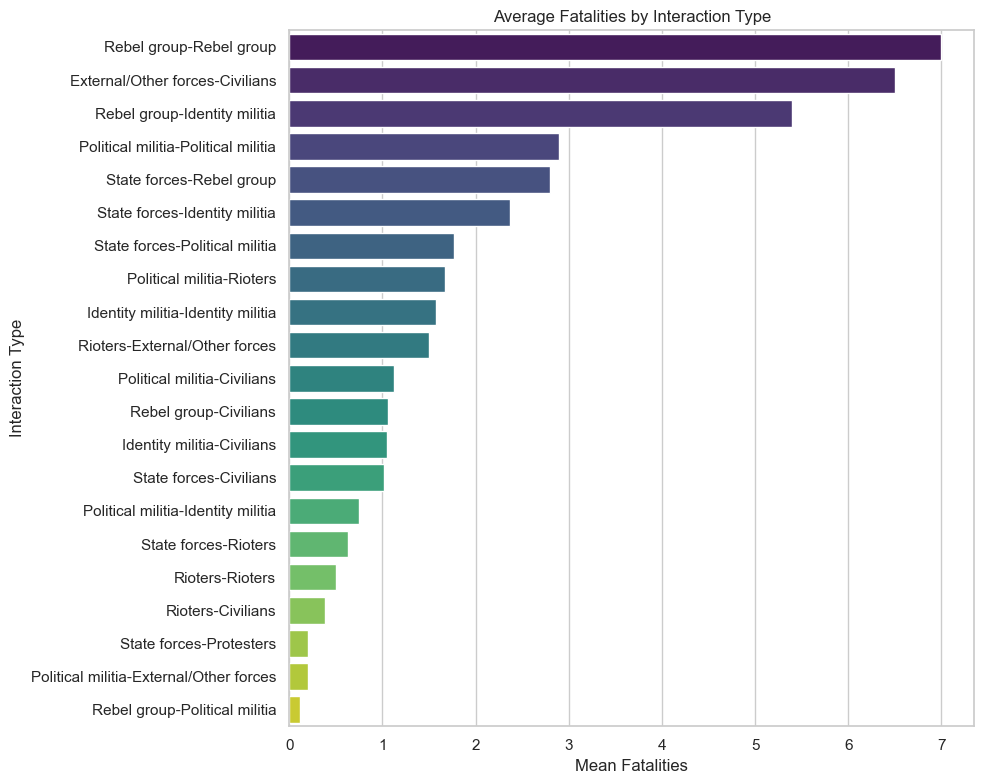

In [ ]:
### which interactions are more deadly?
### Average Fatalities by Event Type - Rebel group-rebel group interaction result in more fatalities

fatal_by_type = df.groupby('interaction')['fatalities'].mean()
fatal_df = fatal_by_type.reset_index()
fatal_df = fatal_df[fatal_df['fatalities'] > 0]
fatal_df = fatal_df.sort_values(by='fatalities', ascending=False)


plt.figure(figsize=(10, 8))
sns.barplot(data=fatal_df, y='interaction', x='fatalities', palette="viridis")
plt.title("Average Fatalities by Interaction Type")
plt.xlabel("Mean Fatalities")
plt.ylabel("Interaction Type")
plt.tight_layout()
plt.show()

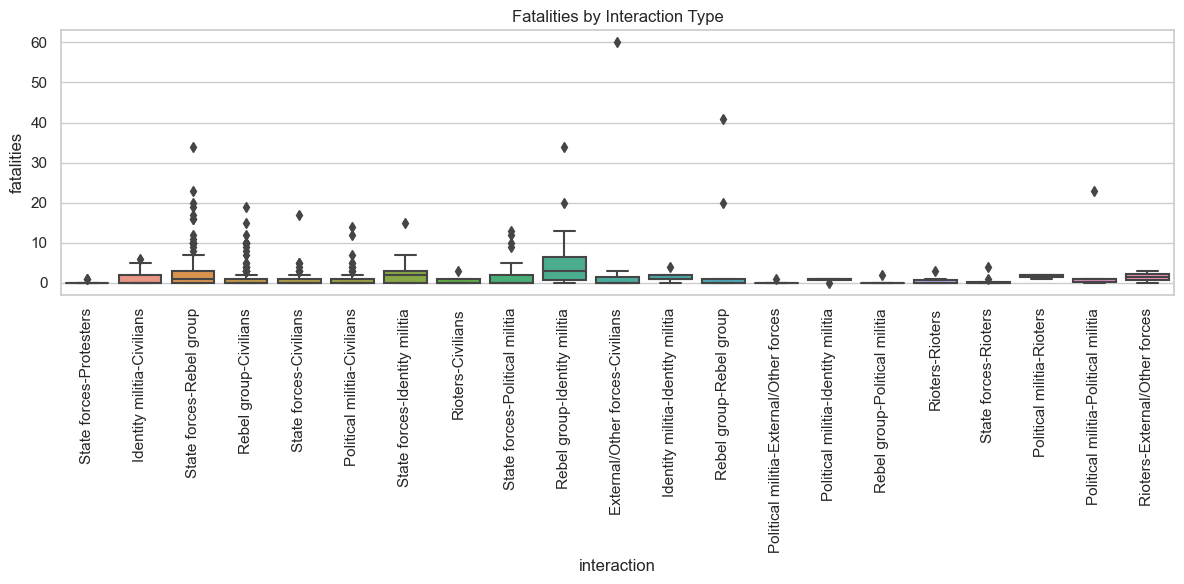

In [ ]:
### Which interactions are more deadly?

### Distribution of fatalities by interaction type — Rebel Group–Identity Militia shows highest median.
### This boxplot also reveals outliers that likely inflated average fatalities
### for two top interaction types in the bar chart above.

nonzero_interactions = df.groupby('interaction')['fatalities'].sum()
nonzero_interactions = nonzero_interactions[nonzero_interactions > 0].index
subset = df[df['interaction'].isin(nonzero_interactions)]
plt.figure(figsize=(12, 6))
sns.boxplot(data=subset, x='interaction', y='fatalities')
plt.title("Fatalities by Interaction Type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

/Users/namigabbasov/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/namigabbasov/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/namigabbasov/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


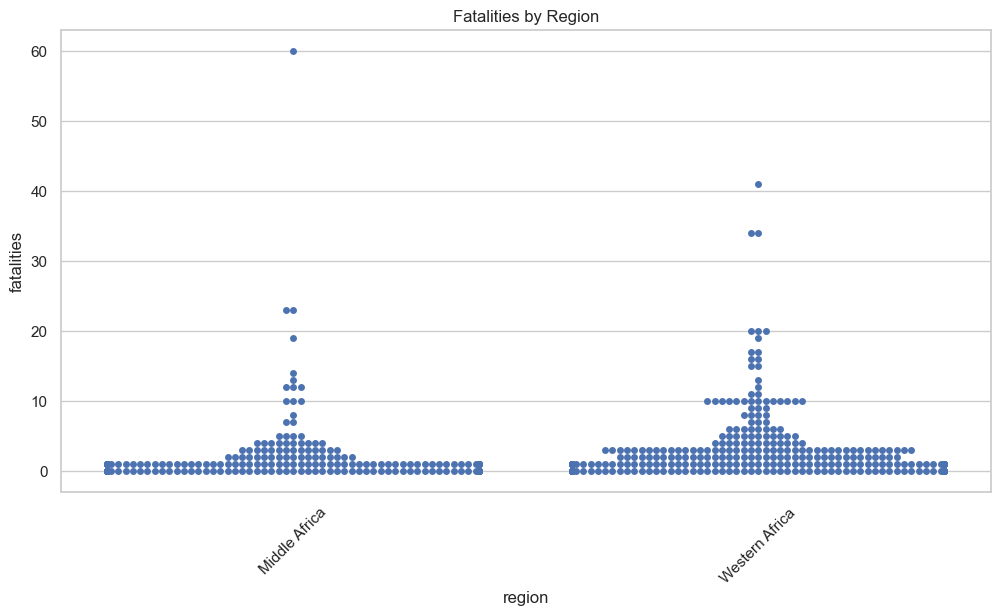

In [ ]:
sns.swarmplot(x='region', y='fatalities', data=df)
plt.title("Fatalities by Region")
plt.xticks(rotation=45)
plt.show()

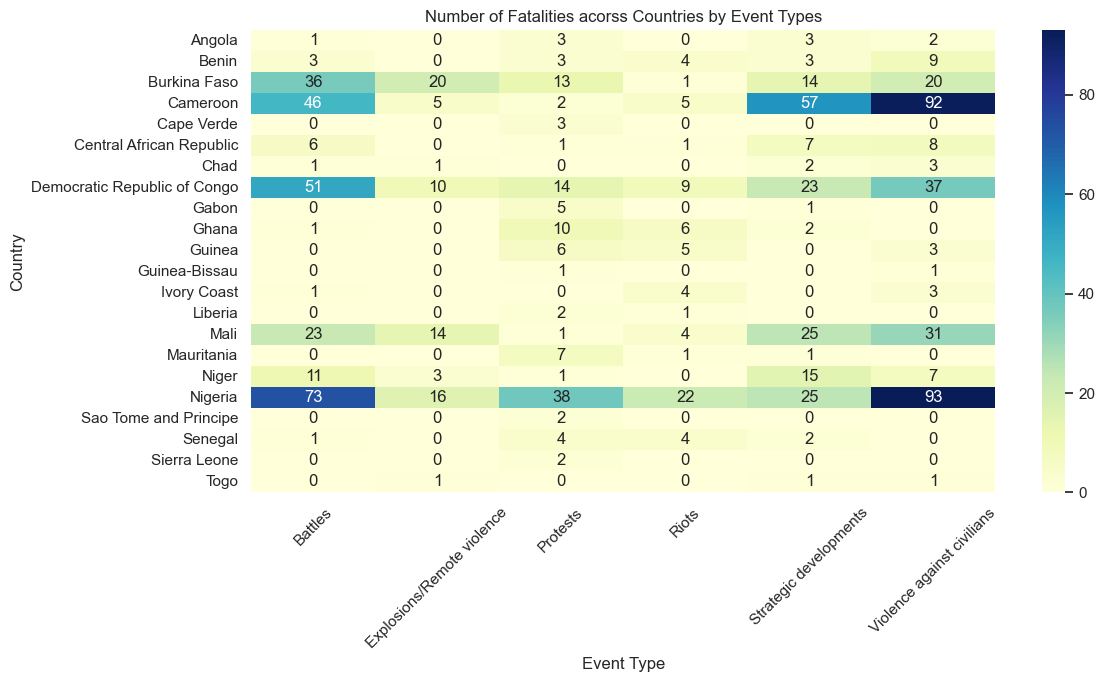

In [ ]:
### Nigeria had highest fatalities almost in all event types.

countries = df['country'].value_counts().index
events = df['event_type'].value_counts().index

event_heatmap = pd.crosstab(df[df['country'].isin(countries)]['country'],
                                df[df['event_type'].isin(events)]['event_type'])

sns.heatmap(event_heatmap, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Number of Fatalities acorss Countries by Event Types")
plt.xlabel("Event Type")
plt.ylabel("Country")
plt.xticks(rotation=45)
plt.show()

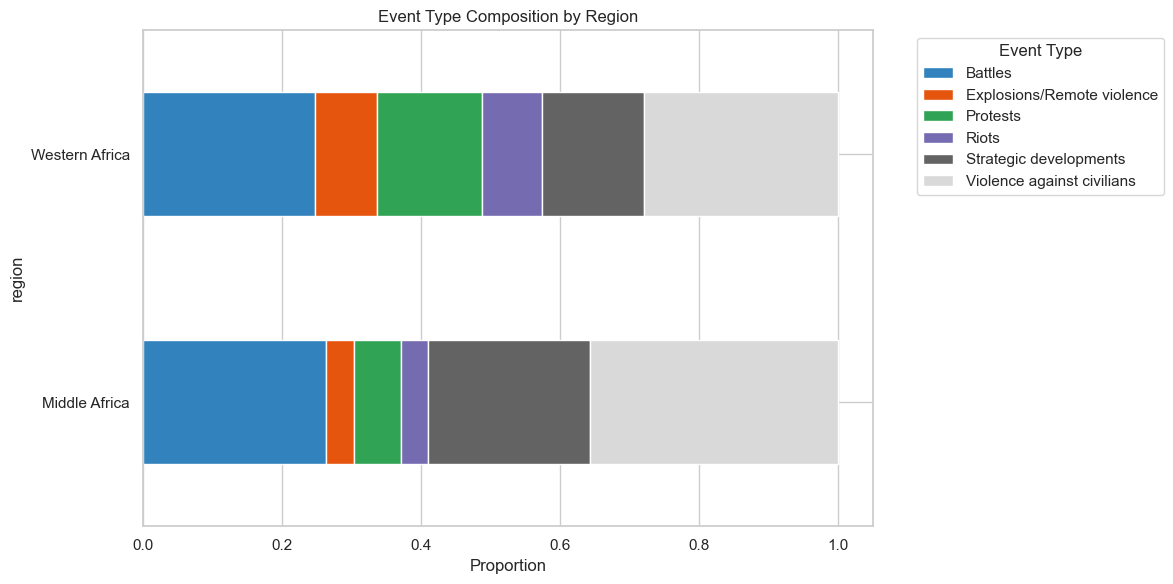

In [ ]:
df_region_type = pd.crosstab(df['region'], df['event_type'], normalize='index')
df_region_type.plot(kind='barh', stacked=True, cmap='tab20c')
plt.title("Event Type Composition by Region")
plt.xlabel("Proportion")
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

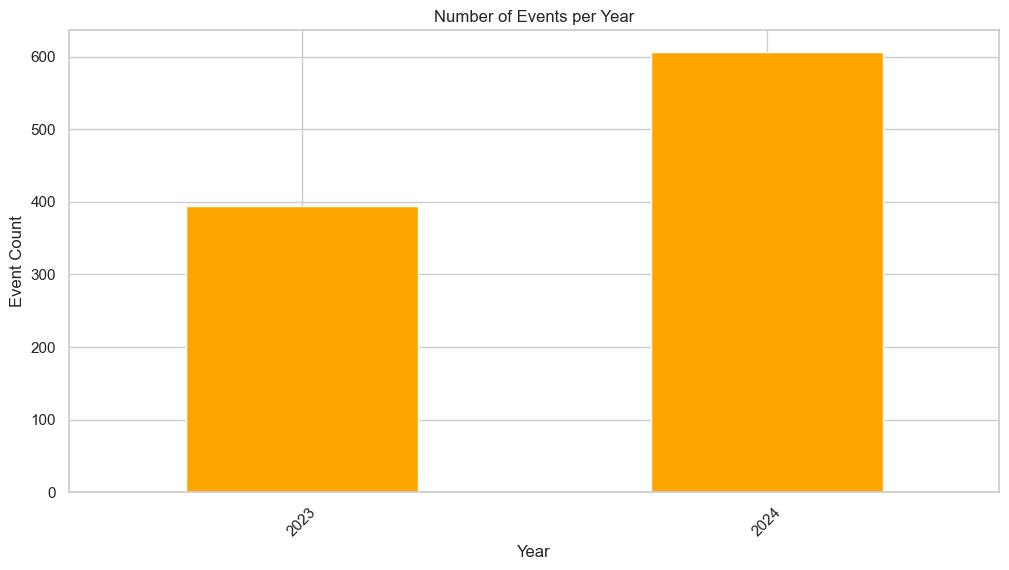

In [ ]:
### Event count per year
df['year'].value_counts().sort_index().plot(kind='bar', color='orange')
plt.title("Number of Events per Year")
plt.xlabel("Year")
plt.ylabel("Event Count")
plt.xticks(rotation=45)
plt.show()

### 5. Temporal Trends

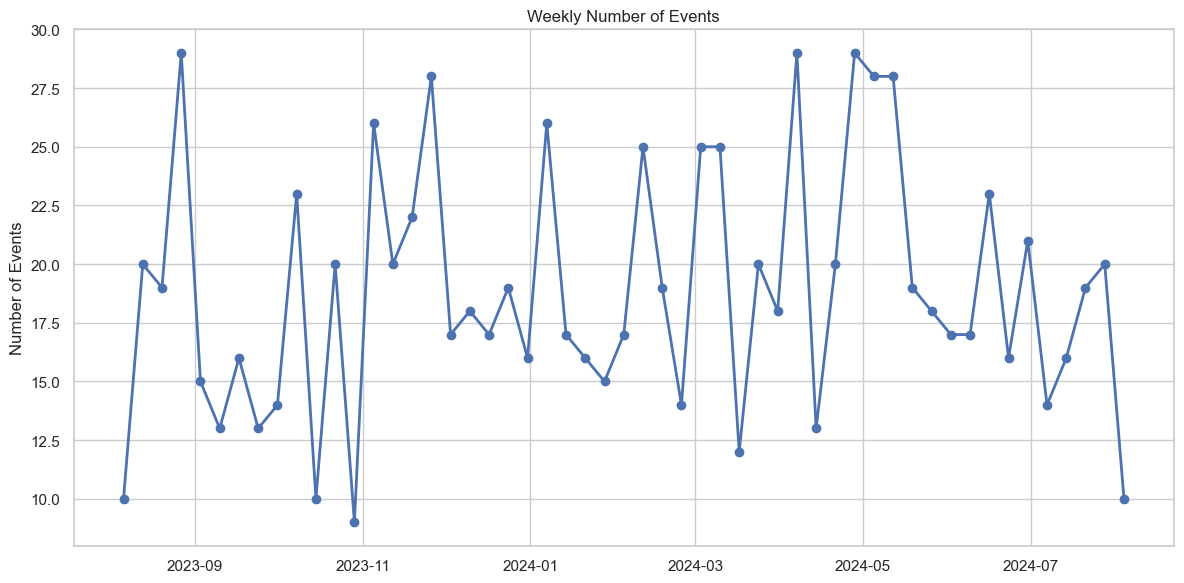

In [ ]:
df['event_date'] = pd.to_datetime(df['event_date'], errors='coerce')

weekly_data = df.set_index('event_date').resample('W').size()
plt.figure(figsize=(12, 6))
plt.plot(weekly_data.index, weekly_data.values, marker='o', linestyle='-', linewidth=2)
plt.ylabel("Number of Events")
plt.title("Weekly Number of Events")
plt.grid(True)
plt.tight_layout()
plt.show()

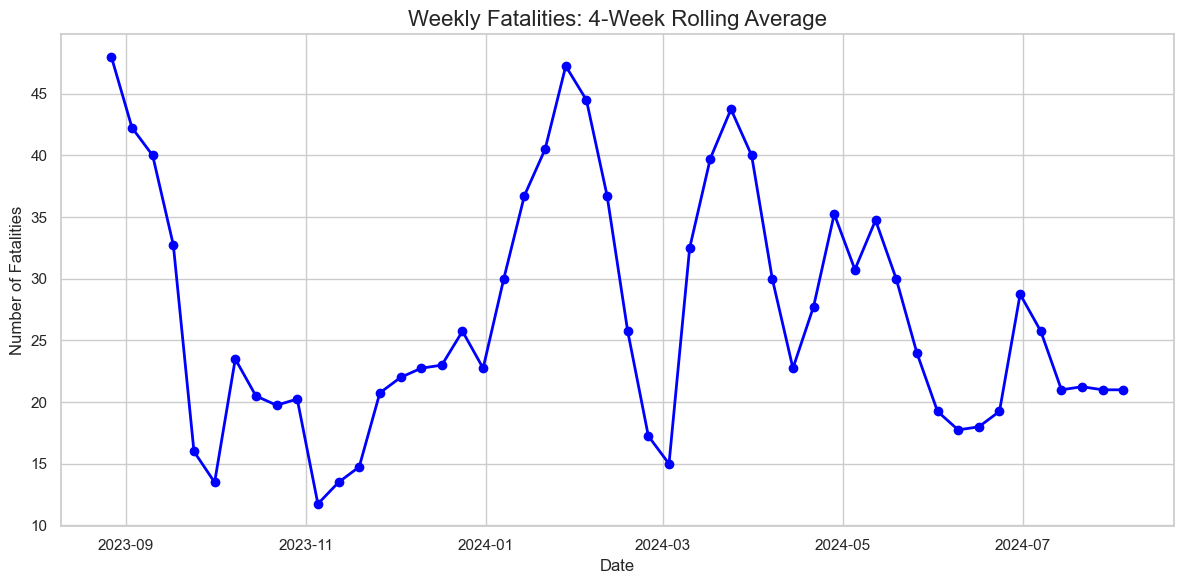

In [ ]:
df['event_date'] = pd.to_datetime(df['event_date'])
rolling_weekly_fatalities = (df.set_index('event_date').resample('W')['fatalities'].sum().rolling(window=4).mean())
plt.figure(figsize=(12, 6))
plt.plot(rolling_weekly_fatalities.index, rolling_weekly_fatalities.values, color='blue', linewidth=2, marker='o')

plt.title("Weekly Fatalities: 4-Week Rolling Average", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Fatalities", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

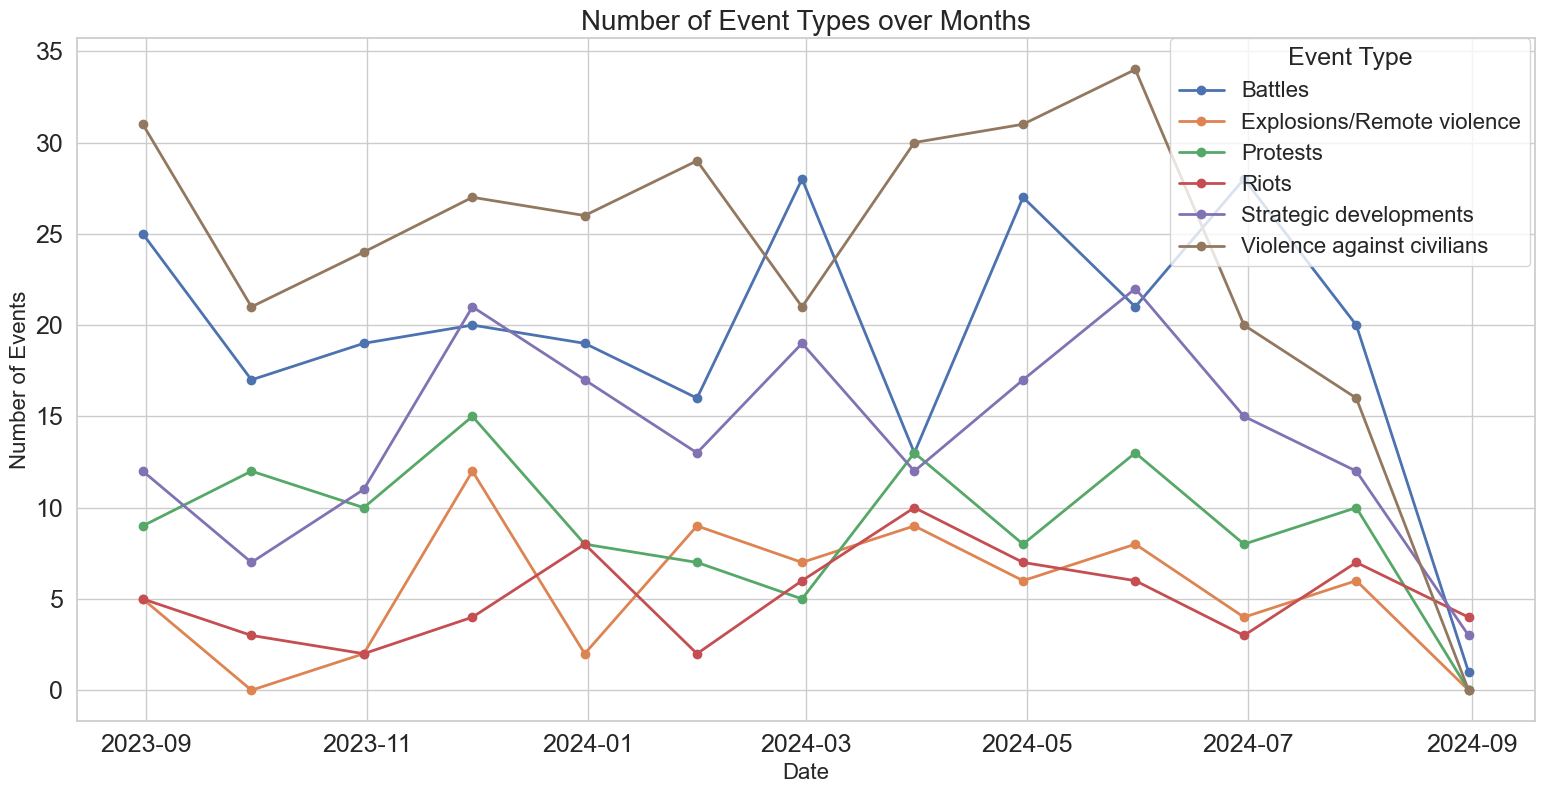

In [ ]:
trend_data = (df.groupby([df['event_date'], 'event_type']).size().unstack().resample('ME').sum())
plt.figure(figsize=(16, 8))
for column in trend_data.columns:
    plt.plot(trend_data.index, trend_data[column], label=column, marker='o', linewidth=2)

plt.title("Number of Event Types over Months", size=20)
plt.xlabel("Date", size=16)
plt.ylabel("Number of Events", size=16)
plt.legend(title='Event Type', bbox_to_anchor=(.75, 1), loc='upper left', borderaxespad=0., fontsize=16, title_fontsize=18)
plt.tight_layout()
plt.xticks(size=18)
plt.yticks(size=18)
plt.show()

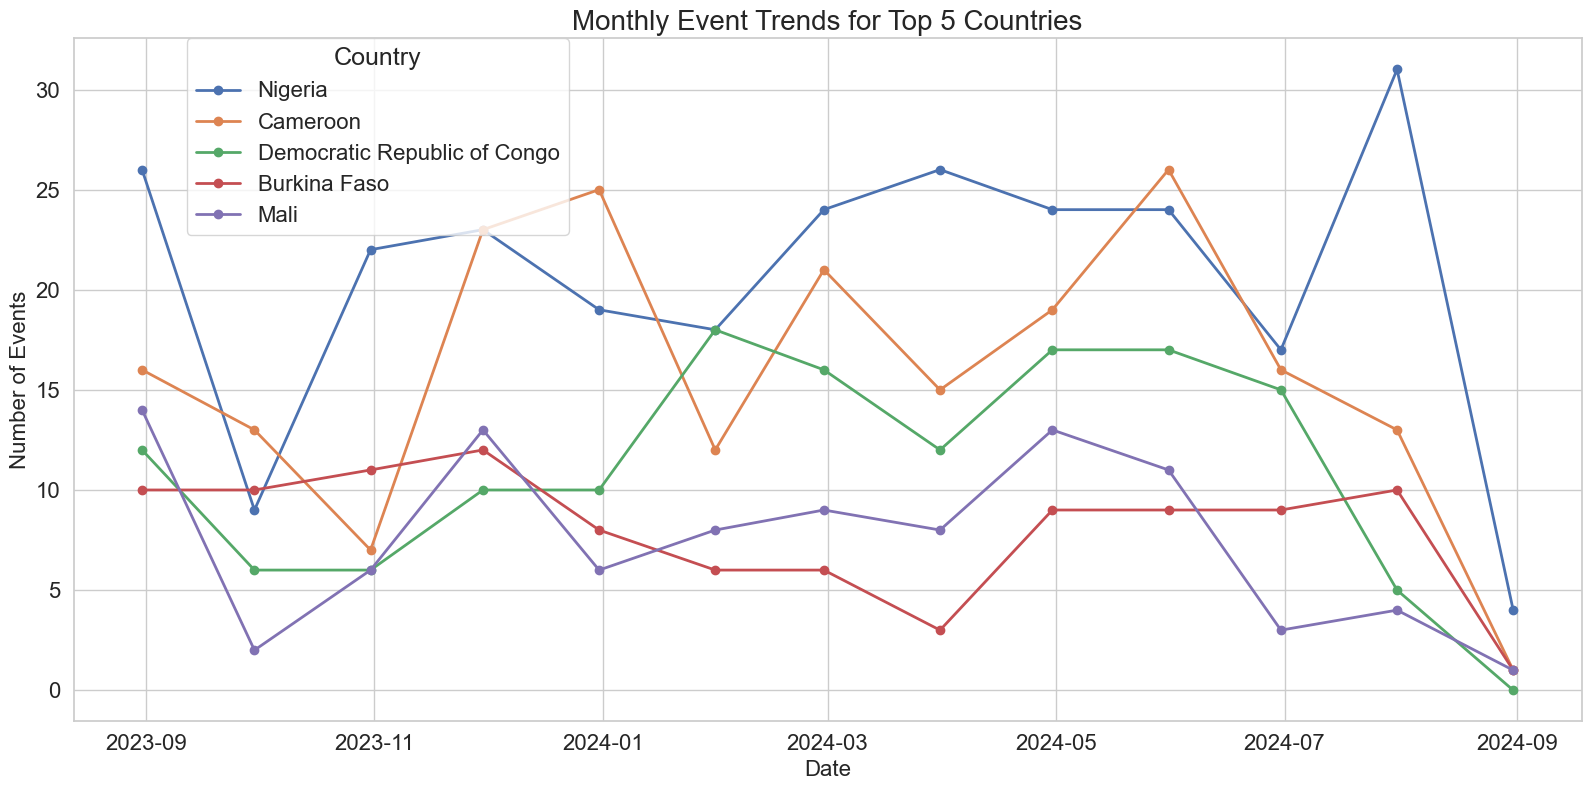

In [ ]:
trend_data_all = (df.groupby([df['event_date'], 'country']).size().unstack().resample('ME').sum())
top5_countries = trend_data_all.sum().nlargest(5).index

trend_data1 = trend_data_all[top5_countries]
plt.figure(figsize=(16, 8))
for column in trend_data1.columns:
    plt.plot(trend_data1.index, trend_data1[column], label=column, marker='o', linewidth=2)

plt.title("Monthly Event Trends for Top 5 Countries", size=20)
plt.xlabel("Date", size=16)
plt.ylabel("Number of Events", size=16)
plt.legend(title='Country', bbox_to_anchor=(.075, 1), loc='upper left', borderaxespad=0., fontsize=16, title_fontsize=18)
plt.tight_layout()
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()

### 6. Geospacial Analysis

In [ ]:
### quick heatmap of location of where events happened - Brighter means more events.

heat_data = df[['latitude', 'longitude']].values.tolist()

africa_heatmap = folium.Map(location=[5, 20], zoom_start=4, tiles='CartoDB dark_matter')
HeatMap(heat_data, radius=10).add_to(africa_heatmap)

africa_heatmap

In [ ]:
### heatmap by fatalities -  Brighter means where most fatalities happened
heat_data = [[row['latitude'], row['longitude'], row['fatalities']]
             for _, row in df[df['fatalities'] > 0].iterrows()]

m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=4.5)
HeatMap(heat_data, radius=15, blur=10).add_to(m)
m

In [ ]:
### interactive map. closer viewing will shows event date, country, event type, fatalities, interaction, notes

### for instance
#Date: 2023-12-13 00:00:00
#Country: Central African Republic
#Event Type: Strategic developments
#Fatalities: 0
#Interaction: Political militia-Civilians
#Notes: Looting: On 13 December 2023, an unidentified armed group looted 1 motorbike 12 km south of Birao (Ridina, Birao, Vakaga) from travelling civilians....

africa_map = folium.Map(location=[5, 20], zoom_start=3.5, tiles="cartodb positron")


event_colors = {
    "Violence against civilians": "red",
    "Battles": "darkred",
    "Strategic developments": "blue",
    "Protests": "orange",
    "Explosions/Remote violence": "purple",
    "Riots": "green"}
marker_cluster = MarkerCluster().add_to(africa_map)
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4 + min(row['fatalities'], 10) * 0.5,
        color=event_colors.get(row['event_type'], "gray"),
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(f"""
            <b>Date:</b> {row['event_date']}<br>
            <b>Country:</b> {row['country']}<br>
            <b>Event Type:</b> {row['event_type']}<br>
            <b>Fatalities:</b> {row['fatalities']}<br>
            <b>Interaction:</b> {row['interaction']}<br>
            <b>Notes:</b> {row['notes'][:300]}...
        """, max_width=300)
    ).add_to(marker_cluster)
africa_map

In [ ]:
### Animation

### Animation becomes especially useful when visualizing temporal dynamics over many years
### as it can reveal patterns, escalation, or diffusion of events over time.

features = []
for _, row in df.iterrows():
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['longitude'], row['latitude']],
        },
        'properties': {
            'time': row['event_date'].strftime('%Y-%m-%dT%H:%M:%S'),
            'popup': f"{row['event_type']} ({row['fatalities']} fatalities) - {row['country']}",
            'icon': 'circle',
            'iconstyle': {
                'fillColor': 'red' if row['fatalities'] > 0 else 'blue',
                'fillOpacity': 0.6,
                'stroke': 'true',
                'radius': 6
            }
        }
    }
    features.append(feature)
geojson = {
    'type': 'FeatureCollection',
    'features': features}


m = folium.Map(location=[5, 20], zoom_start=4, tiles="cartodb positron")
TimestampedGeoJson(data=geojson,transition_time=500,loop=False,auto_play=True,add_last_point=True,period='P1D').add_to(m)
m

In [ ]:
### I wanted to explore dispersion of single event - protests

event_type_filter = 'Protests'
filtered = df[df['event_type'] == event_type_filter]

event_map = folium.Map(location=[5, 20], zoom_start=4, tiles='cartodb positron')

for _, row in filtered.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        color="blue",
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['event_date']} - {row['location']}"
    ).add_to(event_map)
event_map

In [ ]:
### Dispersion of Disorder type
disorder_colors = {
    'Political violence': 'red',
    'Demonstrations': 'blue',
    'Strategic developments': 'green'
}

m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=4.2)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=disorder_colors.get(row['disorder_type'], 'gray'),
        popup=f"""
        <b>Type:</b> {row['event_type']}<br>
        <b>Date:</b> {row['event_date']}<br>
        <b>Fatalities:</b> {row['fatalities']}
        """,
        fill=True
    ).add_to(m)

m

## <center> **Question 2: Text Classification**

---

### 1. Problem Definition and Motivation

In this section, I address task of classifying conflict-related event descriptions from 'notes' column into predefined event types. This is important because manual labeling of such events is not only time-consuming and resource-intensive, but also prone to inconsistencies across countries, languages, and reporting organizations. As conflict datasets continue to grow in volume and complexity, manual annotation becomes increasingly unsustainable. By developing automated classification pipeline using natural language processing, we can enable researchers, policymakers, and humanitarian actors to monitor conflict in real time. Such models also support scalable conflict tracking by turning unstructured narrative text into structured, actionable data.

---

### 2. Modeling Approaches

To classify conflict event descriptions, I implemented and compared two major types of modeling pipelines:

- Approach 1: Machine Learning with Bag-of-Words
- Approach 2: Transformer-based models: BERT and RoBERTa

#### 2.1 Machine Learning with Bag-of-Words

I first preprocess text using standard steps including lowercasing, punctuation removal etc. I then convert text into numerical features using TF-IDF vectorization. I also examined potential class imbalance issues and applied `class_weight='balanced'` in some ML models.

I first trained logistic regression as starter. Then, I trained more classifiers using loop. These included both single estimators and ensemble methods:

- Logistic Regression
- Random Forest
- Gradient Boosting
- XGBoost
- Support Vector Classifier (SVC)
- Linear SVM
- Decision Tree
- Neural Network (MLP)
- AdaBoost
- Bagging

Each classifier was trained, evaluated on test set, and visualized using confusion matrix. Among them, Linear SVM consistently performed best. It achieved ~90% accuracy and close to 90% precision, recall, and F1 scores. This is expected. SVMs are well-suited to handling high-dimensional sparse feature spaces like TF-IDF. Their robustness to irrelevant features and ability to find optimal decision boundaries make them particularly effective for text classification.Because of this, I conducted hyperparameter optimization for Linear SVM, but performance remained largely unchanged.

#### 2.2 Transformer-Based Models: BERT and RoBERTa

To further improve performance, I fine-tuned two transformer-based models: `bert-base-uncased` and `roberta-base`. Before training, I analyzed token lengths of event notes, which ranged between 25 and 180 tokens — well within 512-token input limit, which is max token length. These models outperform traditional methods by capturing contextual semantics through deep, bidirectional attention. Unlike BoW, they recognize word meaning based on surrounding context.

Both models performed exceptionally well, reaching around 95% accuracy, precision, recall, and F1. However, small variations can occur across runs due to stochastic elements in GPU-based training. While CPU training improves reproducibility, it is significantly slower, which limits practicality.

---

### 3. Other Modeling Approaches

While above methods produced strong results, several additional modeling strategies could be applied to this problem — either as alternatives or complementary enhancements.

#### Bidirectional LSTM with Pretrained Word Embeddings

In a separate project, I have implemented Bidirectional LSTM (BiLSTM) architecture that used GloVe word embeddings as input. GloVe embeddings capture semantic similarity between words, which helps model generalize to varied language use. BiLSTM reads text sequences in both directions, allowing model to learn from both preceding and following words - key advantage in understanding conflict narratives with subtle variations. This approach was not feasible to run all my codes in your environement due to downloading constraints: it would have required downloading and preprocessing large pretrained embedding files.

#### Knowledge Distillation
Although I used full-size transformer models such as BERT and RoBERTa, promising next step would be to apply knowledge distillation to make the model more efficient and lightweight.In knowledge distilation, smaller models are trained to imitate predictions of larger model. Mmaller model learns not only from ground-truth labels but also from soft probabilities output by larger teacher model. Good for faster inference times and reduced memory.


#### Ensembling Traditional ML and Deep Learning

This exercise included ensemble models. But these are ensemble of classic ML learners. Further improvements can be made by implementing stacking of predictions from multiple base models from both classic ML and transformer-based models. Stacking can leverage strengths of both traditional ML and deep learning. For instanc, combining BERT's deep semantic power with SVM's precision on short sparse notes to increase overall robustness and accuracy.


#### Zero-Shot Classification Using Natural Language Inference

I am also interested to explore how zero-shot learning can be helpful for this task. It enables classification without labeled training data by framing task as natural language inference problem. For example, using models like `facebook/bart-large-mnli` or `xlm-roberta-large-xnli`, we can assess whether statement like *This text is about a protest* is entailed by event description. Zero-shot classification is particularly useful in conflict event classification where new categories may emerge. Sometimes, labeled data may be limited or unavailable. This method allows flexible application of pre-trained NLI models to unstructured conflict notes without need for retraining.

---


### 1. Bag of Words Approach with ML

In [ ]:
### standard text pre-processing steps in bag of words approach


nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

df['notes_clean'] = df['notes'].apply(clean_text)

X_train, X_test, y_train, y_test = train_test_split(
    df['notes_clean'],
    df['event_type'],
    test_size=0.2,
    random_state=42,
    stratify=df['event_type'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/namigabbasov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/namigabbasov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
### vectorize text
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Accuracy: 0.8700
                            precision    recall  f1-score   support

                   Battles       0.82      0.90      0.86        51
Explosions/Remote violence       0.71      0.86      0.77        14
                  Protests       0.89      1.00      0.94        24
                     Riots       0.91      0.77      0.83        13
    Strategic developments       0.88      0.83      0.86        36
Violence against civilians       0.95      0.84      0.89        62

                  accuracy                           0.87       200
                 macro avg       0.86      0.87      0.86       200
              weighted avg       0.88      0.87      0.87       200



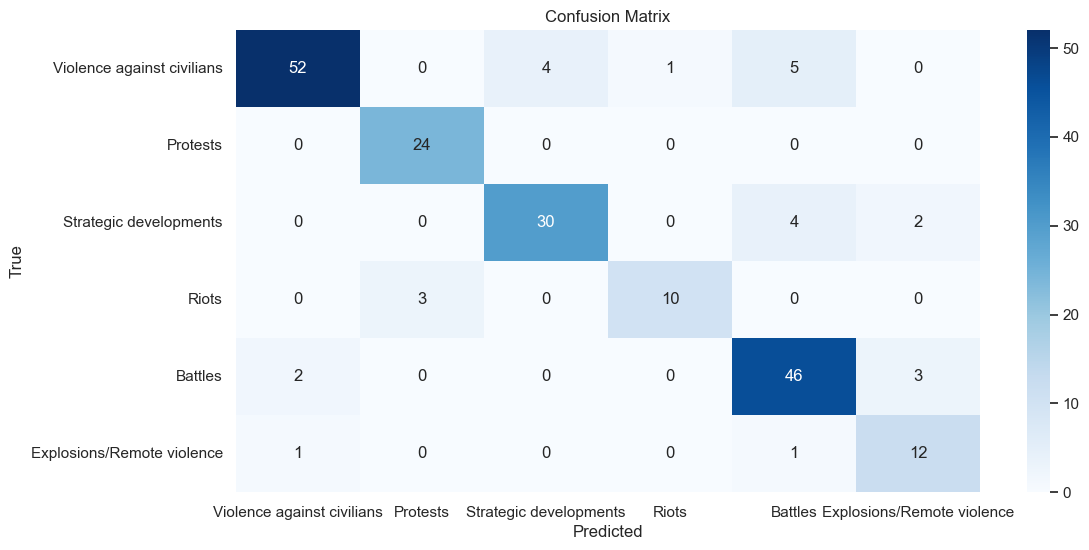

In [ ]:
######## logistic regression


### I begin with logistic regression to explore first

### fit model
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train_vec, y_train)


### predict and evaluate
y_pred = clf.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

### confusion matrix
labels = y_train.unique()
cm = confusion_matrix(y_test, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Training Logistic Regression

Logistic Regression Results:
Accuracy: 0.87
Confusion Matrix:
[[46  3  0  0  0  2]
 [ 1 12  0  0  0  1]
 [ 0  0 24  0  0  0]
 [ 0  0  3 10  0  0]
 [ 4  2  0  0 30  0]
 [ 5  0  0  1  4 52]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        51
           1       0.71      0.86      0.77        14
           2       0.89      1.00      0.94        24
           3       0.91      0.77      0.83        13
           4       0.88      0.83      0.86        36
           5       0.95      0.84      0.89        62

    accuracy                           0.87       200
   macro avg       0.86      0.87      0.86       200
weighted avg       0.88      0.87      0.87       200



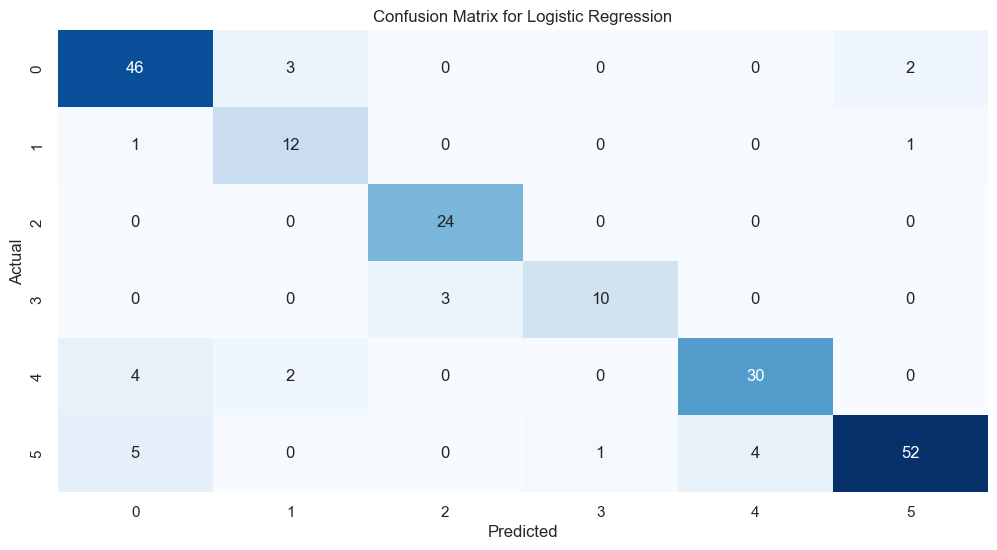


Training Random Forest

Random Forest Results:
Accuracy: 0.85
Confusion Matrix:
[[40  3  0  0  1  7]
 [ 1 11  0  0  0  2]
 [ 0  0 24  0  0  0]
 [ 1  0  3  6  2  1]
 [ 2  1  0  0 30  3]
 [ 3  0  0  0  0 59]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.82        51
           1       0.73      0.79      0.76        14
           2       0.89      1.00      0.94        24
           3       1.00      0.46      0.63        13
           4       0.91      0.83      0.87        36
           5       0.82      0.95      0.88        62

    accuracy                           0.85       200
   macro avg       0.87      0.80      0.82       200
weighted avg       0.86      0.85      0.84       200



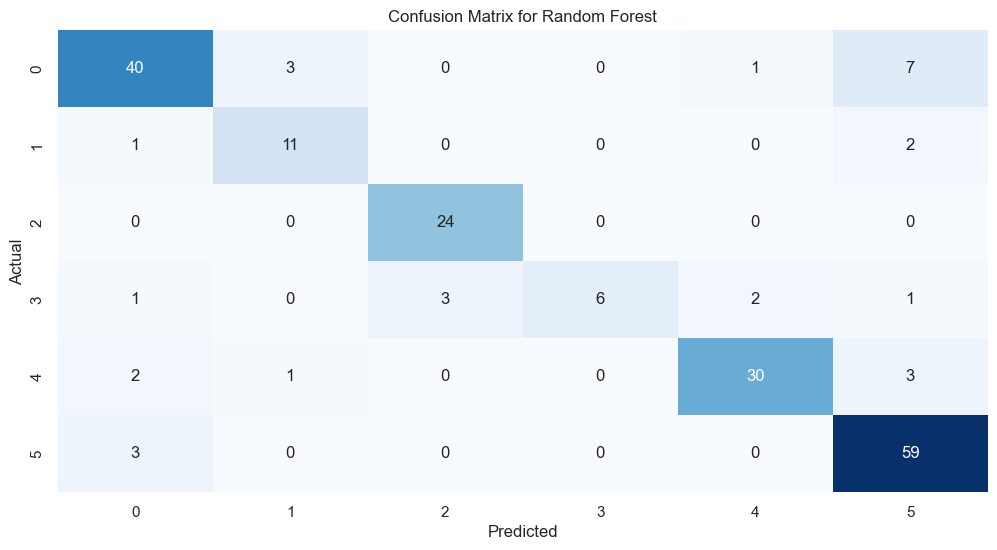


Training Gradient Boosting

Gradient Boosting Results:
Accuracy: 0.81
Confusion Matrix:
[[37  0  0  0  1 13]
 [ 1 10  0  0  1  2]
 [ 0  0 21  3  0  0]
 [ 1  0  2  6  1  3]
 [ 1  0  0  0 32  3]
 [ 3  0  0  1  1 57]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79        51
           1       1.00      0.71      0.83        14
           2       0.91      0.88      0.89        24
           3       0.60      0.46      0.52        13
           4       0.89      0.89      0.89        36
           5       0.73      0.92      0.81        62

    accuracy                           0.81       200
   macro avg       0.83      0.76      0.79       200
weighted avg       0.82      0.81      0.81       200



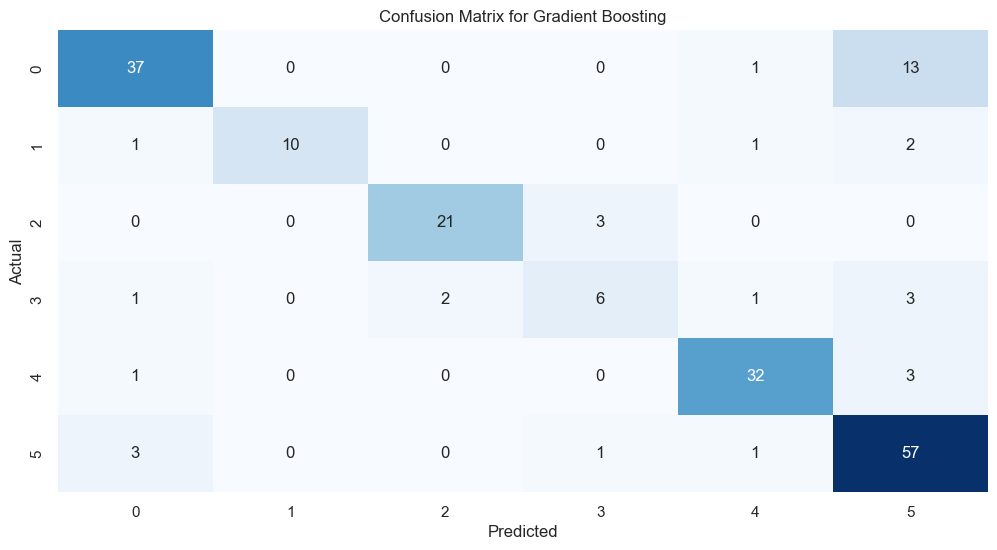


Training XGBoost

XGBoost Results:
Accuracy: 0.83
Confusion Matrix:
[[40  1  0  0  1  9]
 [ 3  9  0  0  0  2]
 [ 0  0 22  2  0  0]
 [ 2  0  2  5  4  0]
 [ 2  1  0  1 30  2]
 [ 1  0  0  0  1 60]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.81        51
           1       0.82      0.64      0.72        14
           2       0.92      0.92      0.92        24
           3       0.62      0.38      0.48        13
           4       0.83      0.83      0.83        36
           5       0.82      0.97      0.89        62

    accuracy                           0.83       200
   macro avg       0.81      0.75      0.77       200
weighted avg       0.83      0.83      0.82       200



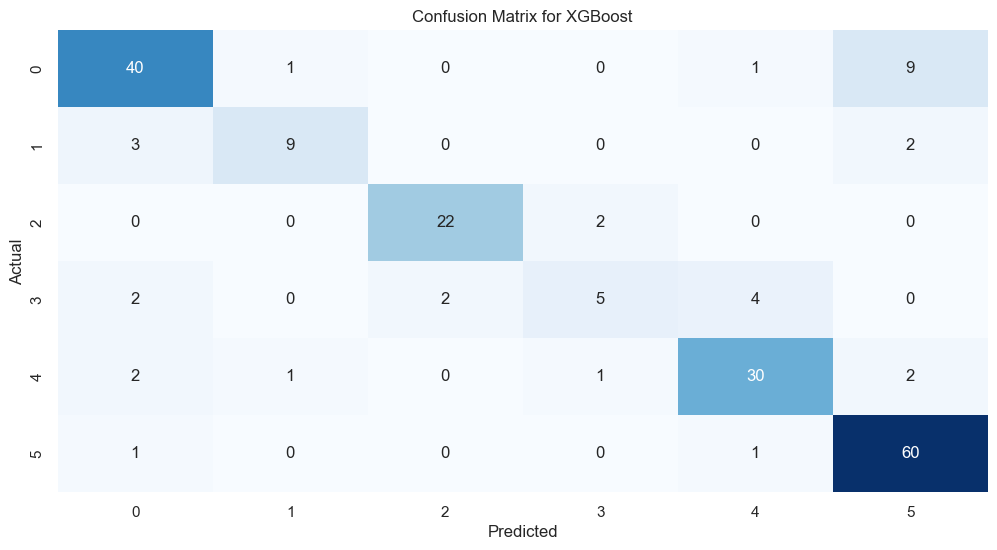


Training Support Vector Classifier

Support Vector Classifier Results:
Accuracy: 0.81
Confusion Matrix:
[[46  0  0  0  0  5]
 [ 5  7  0  0  0  2]
 [ 0  0 22  0  0  2]
 [ 0  0  4  2  0  7]
 [ 4  1  0  0 27  4]
 [ 3  0  0  0  0 59]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        51
           1       0.88      0.50      0.64        14
           2       0.85      0.92      0.88        24
           3       1.00      0.15      0.27        13
           4       1.00      0.75      0.86        36
           5       0.75      0.95      0.84        62

    accuracy                           0.81       200
   macro avg       0.88      0.70      0.72       200
weighted avg       0.84      0.81      0.80       200



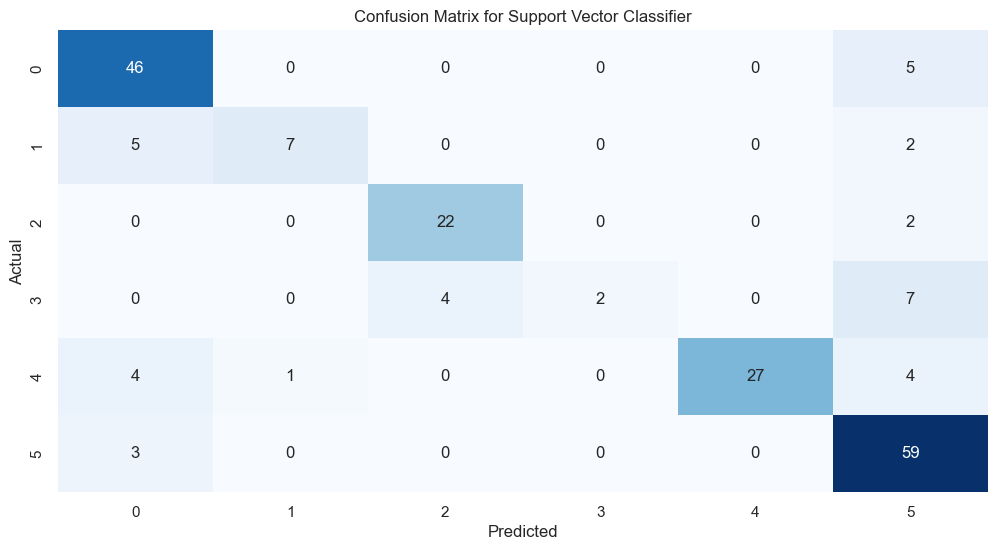


Training Linear SVM

Linear SVM Results:
Accuracy: 0.90
Confusion Matrix:
[[47  1  0  0  0  3]
 [ 1 12  0  0  0  1]
 [ 0  0 23  1  0  0]
 [ 0  0  3  8  2  0]
 [ 2  1  0  0 31  2]
 [ 2  0  0  0  1 59]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        51
           1       0.86      0.86      0.86        14
           2       0.88      0.96      0.92        24
           3       0.89      0.62      0.73        13
           4       0.91      0.86      0.89        36
           5       0.91      0.95      0.93        62

    accuracy                           0.90       200
   macro avg       0.89      0.86      0.87       200
weighted avg       0.90      0.90      0.90       200



/Users/namigabbasov/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


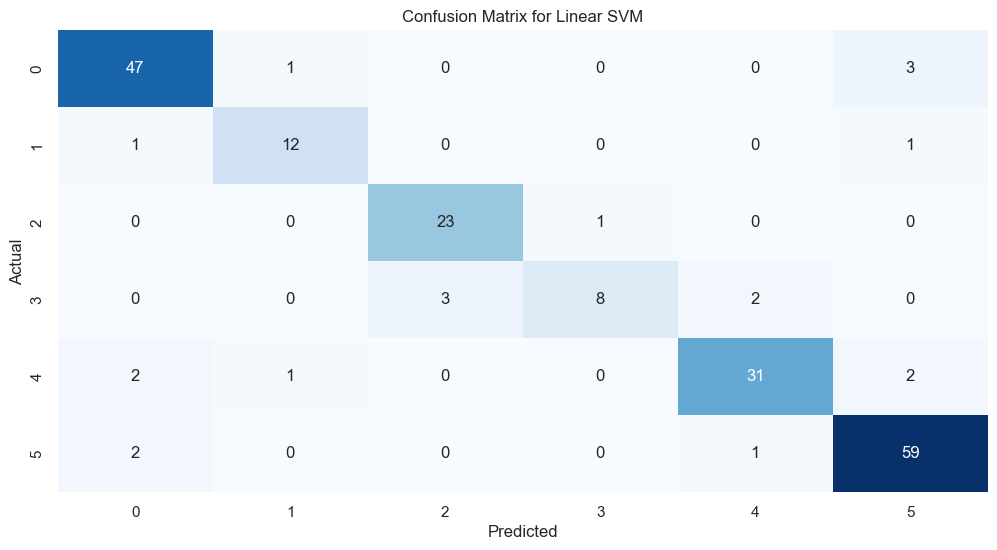


Training Decision Tree

Decision Tree Results:
Accuracy: 0.73
Confusion Matrix:
[[35  5  0  0  1 10]
 [ 3  6  0  0  0  5]
 [ 0  0 20  1  3  0]
 [ 2  0  1  4  4  2]
 [ 4  3  0  0 25  4]
 [ 5  0  0  0  1 56]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70        51
           1       0.43      0.43      0.43        14
           2       0.95      0.83      0.89        24
           3       0.80      0.31      0.44        13
           4       0.74      0.69      0.71        36
           5       0.73      0.90      0.81        62

    accuracy                           0.73       200
   macro avg       0.73      0.64      0.66       200
weighted avg       0.74      0.73      0.72       200



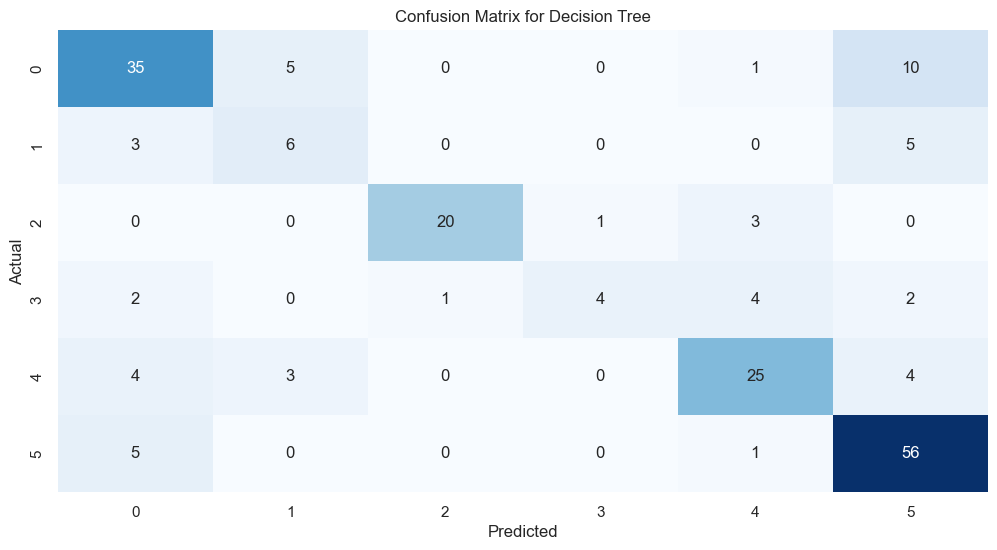


Training Neural Network (MLP)

Neural Network (MLP) Results:
Accuracy: 0.81
Confusion Matrix:
[[43  1  0  0  1  6]
 [ 3  9  0  0  1  1]
 [ 0  0 23  0  0  1]
 [ 0  0  3  9  1  0]
 [ 6  1  0  0 27  2]
 [ 6  0  0  1  3 52]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        51
           1       0.82      0.64      0.72        14
           2       0.88      0.96      0.92        24
           3       0.90      0.69      0.78        13
           4       0.82      0.75      0.78        36
           5       0.84      0.84      0.84        62

    accuracy                           0.81       200
   macro avg       0.83      0.79      0.81       200
weighted avg       0.82      0.81      0.81       200



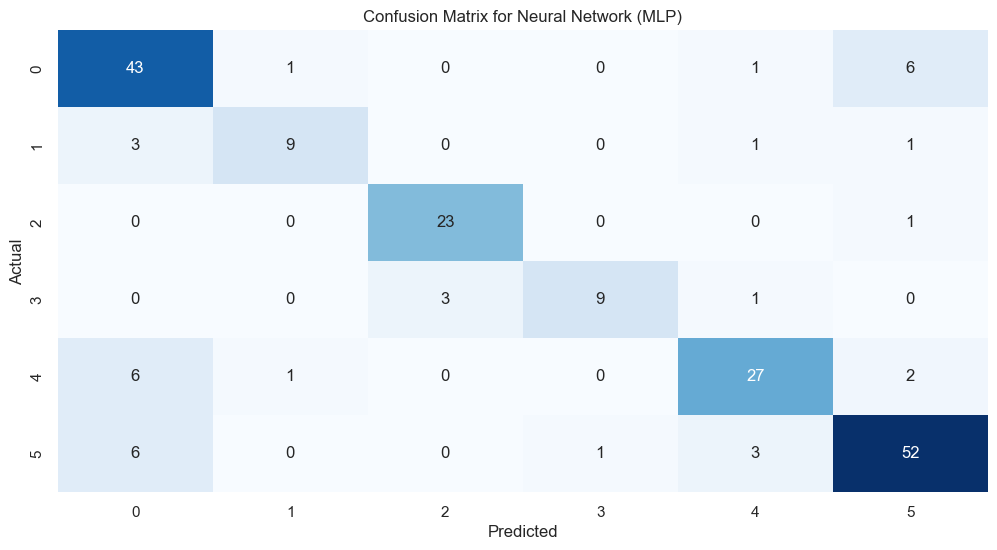


Training AdaBoost

AdaBoost Results:
Accuracy: 0.69
Confusion Matrix:
[[22  0  0  1  7 21]
 [ 4  4  0  0  2  4]
 [ 1  0 19  0  4  0]
 [ 1  0  1  5  6  0]
 [ 0  2  0  0 34  0]
 [ 2  0  0  0  7 53]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.43      0.54        51
           1       0.67      0.29      0.40        14
           2       0.95      0.79      0.86        24
           3       0.83      0.38      0.53        13
           4       0.57      0.94      0.71        36
           5       0.68      0.85      0.76        62

    accuracy                           0.69       200
   macro avg       0.74      0.62      0.63       200
weighted avg       0.71      0.69      0.67       200



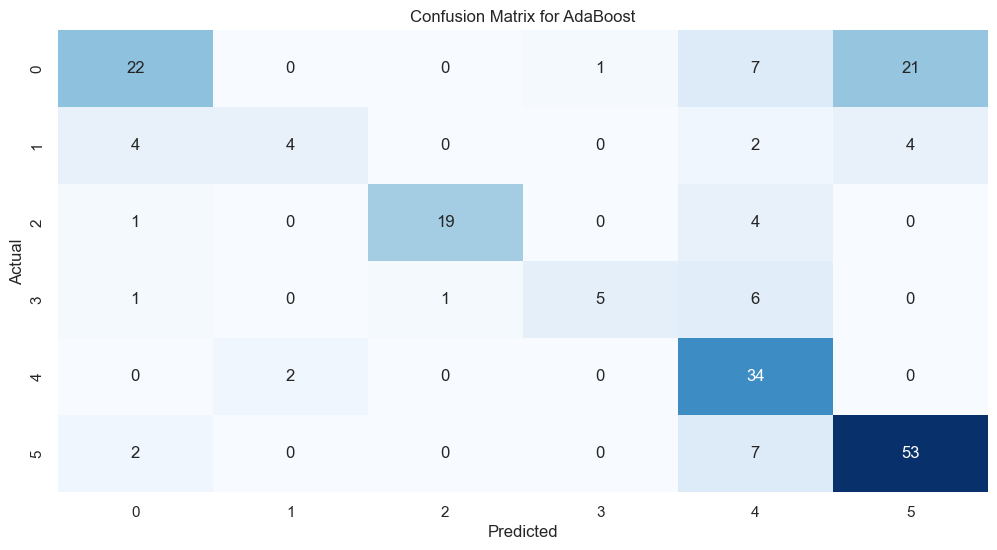


Training Bagging

Bagging Results:
Accuracy: 0.78
Confusion Matrix:
[[36  3  0  0  1 11]
 [ 5  7  0  0  0  2]
 [ 0  0 20  2  2  0]
 [ 3  0  1  5  3  1]
 [ 1  0  0  0 34  1]
 [ 7  0  0  0  1 54]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        51
           1       0.70      0.50      0.58        14
           2       0.95      0.83      0.89        24
           3       0.71      0.38      0.50        13
           4       0.83      0.94      0.88        36
           5       0.78      0.87      0.82        62

    accuracy                           0.78       200
   macro avg       0.78      0.71      0.73       200
weighted avg       0.78      0.78      0.77       200



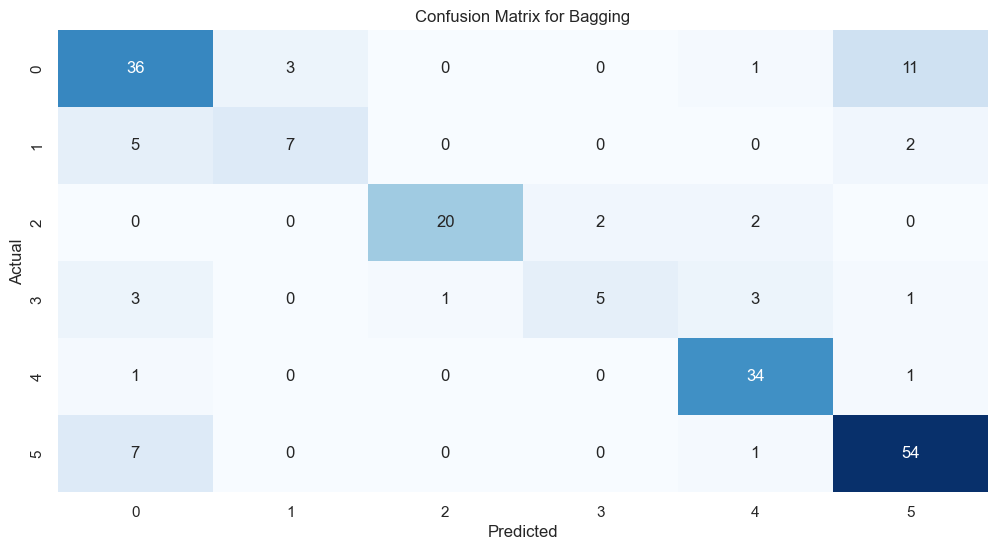

In [ ]:
######## ML classifiers in loop

### convert categorical string labels into integer values - XGBoost requires this.
le = LabelEncoder()
y_train= le.fit_transform(y_train)
y_test= le.transform(y_test)
label_names = le.classes_


### loop grabs each classifier from dictionary(key: value), trains it, predicts on test, and plots CM
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Support Vector Classifier': SVC(),
    'Linear SVM': LinearSVC(max_iter=10000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Neural Network (MLP)': MLPClassifier(random_state=42, max_iter=1000),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Bagging': BaggingClassifier(random_state=42)}


for name, clf in classifiers.items():
    print(f'\nTraining {name}')
    clf.fit(X_train_vec, y_train)        ### Train model
    y_pred = clf.predict(X_test_vec)     ### Predict on test set

    ### obtain evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f'\n{name} Results:')
    print(f'Accuracy: {accuracy:.2f}')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(report)

    ### finally plot confusion matrix
    ###plt.figure(figsize=(6, 4), dpi=300)  ### if plots are small, take comment out
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

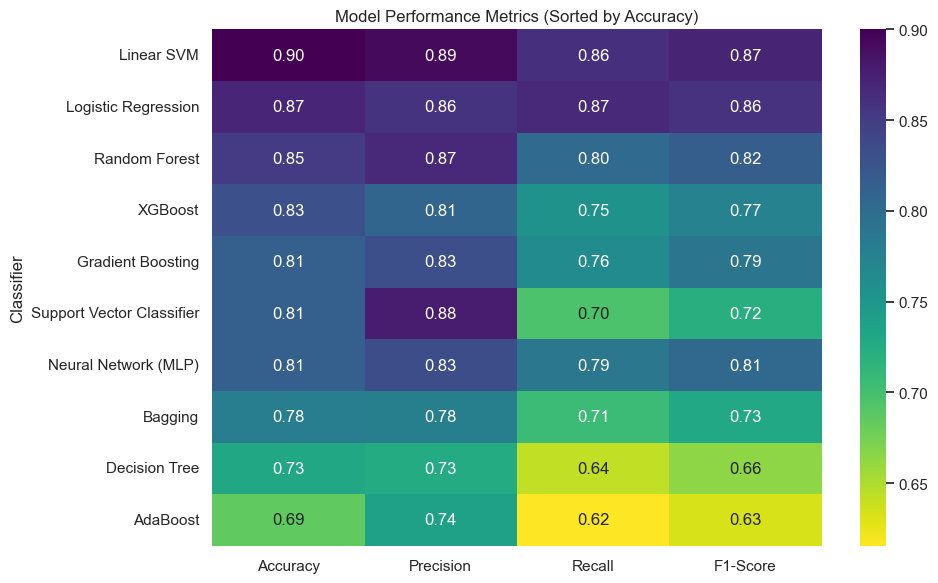

In [ ]:
######## metrics from all classifiers in heatmap

metrics_results = {
    "Classifier": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []}


for name, clf in classifiers.items():
    y_pred = clf.predict(X_test_vec)

    metrics_results["Classifier"].append(name)
    metrics_results["Accuracy"].append(accuracy_score(y_test, y_pred))
    metrics_results["Precision"].append(precision_score(y_test, y_pred, average='macro'))
    metrics_results["Recall"].append(recall_score(y_test, y_pred, average='macro'))
    metrics_results["F1-Score"].append(f1_score(y_test, y_pred, average='macro'))

metrics_df = pd.DataFrame(metrics_results).set_index("Classifier")
metrics_df_sorted = metrics_df.sort_values(by="Accuracy", ascending=False)

plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df_sorted, annot=True, cmap='viridis_r', fmt=".2f")
plt.title("Model Performance Metrics (Sorted by Accuracy)")
plt.tight_layout()
plt.show()

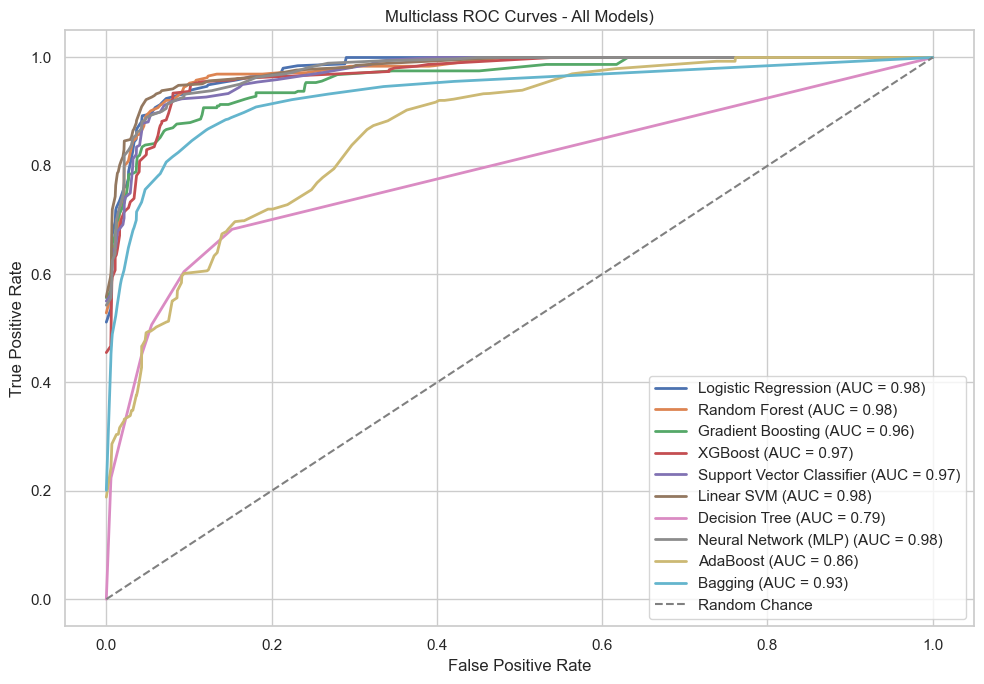

In [ ]:
######### ROC-AUC from all classifers


y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 7))

for name, clf in classifiers.items():
    # Use predict_proba if available
    if hasattr(clf, "predict_proba"):
        try:
            y_score = clf.predict_proba(X_test_vec)
        except Exception as e:
            print(f"Skipping {name}: {e}")
            continue ### this is because linear SVM is not probabilitistic model
    elif hasattr(clf, "decision_function"):
        try:
            y_score = clf.decision_function(X_test_vec)

            if len(y_score.shape) == 1:
                y_score = np.vstack([1 - y_score, y_score]).T

        except Exception as e:
            print(f"Skipping {name}: {e}")
            continue

    else:
        print(f"Skipping {name}: No predict_proba or decision_function")
        continue

    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        try:
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        except:
            continue

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(fpr))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(fpr)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(fpr)

    auc_score = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC = {auc_score:.2f})", linewidth=2)



### plot baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance') #### AUC = 50

### plot
plt.title("Multiclass ROC Curves - All Models)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
####### Hyperparameter Optimization



### since Linear SVM yielded best results, I conduct hyperparameter optimization below. It is an aggressive search.


def tune_linear_svc(X_train_vec, y_train, X_test_vec, y_test, scoring='f1_macro'):
    """
    tune LinearSVC with expanded parameter grid and print best results.
    """

    ### expanded parameter grid
    param_grid = {
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'class_weight': [None, 'balanced'],
        'loss': ['squared_hinge', 'hinge']}

    ### model
    svc = LinearSVC(max_iter=10000, random_state=42, dual='auto')

    ### GridSearchCV
    grid_search = GridSearchCV(
        svc,
        param_grid,
        cv=5,
        scoring=scoring,
        verbose=2,
        n_jobs=-1)

    ### fit
    grid_search.fit(X_train_vec, y_train)

    ### best model evaluation
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_vec)

    print("\nBest Parameters Found:")
    print(grid_search.best_params_)
    print(f"\nBest Cross-Validated Score ({scoring}): {grid_search.best_score_:.4f}")

    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_pred))

    ###  confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    labels = np.unique(y_test)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix of Best LinearSVC")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    ### print metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print("\nFinal Test Set Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    return best_model, grid_search.best_params_, grid_search.best_score_

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best Parameters Found:
{'C': 1, 'class_weight': 'balanced', 'loss': 'squared_hinge'}

Best Cross-Validated Score (f1_macro): 0.8379

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92        51
           1       0.87      0.93      0.90        14
           2       0.88      0.96      0.92        24
           3       0.80      0.62      0.70        13
           4       0.91      0.86      0.89        36
           5       0.92      0.92      0.92        62

    accuracy                           0.90       200
   macro avg       0.88      0.87      0.87       200
weighted avg       0.90      0.90      0.90       200



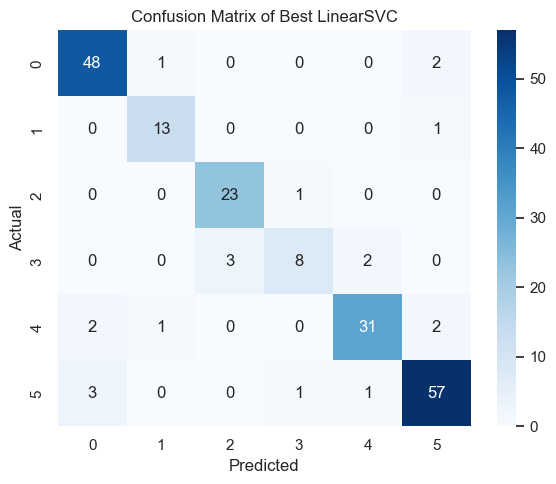


Final Test Set Metrics:
Accuracy : 0.9000
Precision: 0.8813
Recall   : 0.8707
F1 Score : 0.8734


In [ ]:
best_model, best_params, best_score = tune_linear_svc(X_train_vec, y_train, X_test_vec, y_test)

### 2. Text Classification with Transformer-Based Models

In [ ]:
### below, I check if token size is suitable for BERT and Roberta
### It shows tokens are between 25 and 180, suitable for both BERT and Roberta

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


shortest_note = df["notes"].iloc[df["notes"].str.len().idxmin()] ### shortest note
print("\nShortest note:")
print(shortest_note)

longest_note = df["notes"].iloc[df["notes"].str.len().idxmax()]  ### longest note
print("\nLongest note text:")
print(longest_note)

### tokenize shortest note using bert and roberta
bert_tokens_short = bert_tokenizer.tokenize(shortest_note)
roberta_tokens_short = roberta_tokenizer.tokenize(shortest_note)

### tokenize longest note using bert and roberta
bert_tokens_long = bert_tokenizer.tokenize(longest_note)
roberta_tokens_long = roberta_tokenizer.tokenize(longest_note)

### print token size computed with each model for both short and long notes
print("\nToken counts in Shortest Note:")
print(f"BERT token count    : {len(bert_tokens_short)}")
print(f"RoBERTa token count : {len(roberta_tokens_short)}")

print("\nToken counts in Longest Note:")
print(f"BERT token count    : {len(bert_tokens_long)}")
print(f"RoBERTa token count : {len(roberta_tokens_long)}")


Shortest note:
On 9 May 2024, suspected JNIM killed a farmer in Kompa (Karimama, Alibori).

Longest note text:
On 6 August 2023, A FAMa and Wagner convoy en route to Timbuktu stopped at the village of Sambani (Niafunke, Tombouctou). Upon entering the village, a motorcyclist (possibly a JNIM militant) shot at them and escaped. The convoy then gathered at the village center and asked the village chief to urge residents hiding weapons to hand them over, assuring no harm would come to them. Using the mosque's loudspeaker, the chief made the call. Seventeen individuals, including both elders and adults (13 black Tuaregs and 4 Fulani), surrendered their weapons. Despite the chief's protest, these individuals were loaded onto a truck under the premise of being released unharmed. However, about 1 km east of the village, the convoy executed all 17 individuals. Villagers found their bodies shortly after.

Token counts in Shortest Note:
BERT token count    : 26
RoBERTa token count : 25

Token co

/Users/namigabbasov/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


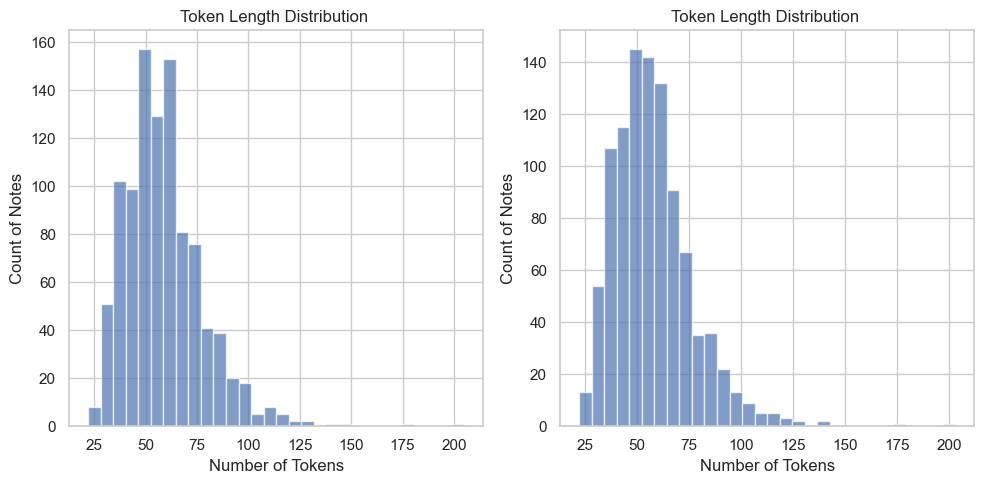

In [ ]:
### distribution of all notes based on their token size

df["bert_tokens"] = df["notes"].apply(lambda x: len(bert_tokenizer.tokenize(x)))
df["roberta_tokens"] = df["notes"].apply(lambda x: len(roberta_tokenizer.tokenize(x)))
ax = df[["bert_tokens", "roberta_tokens"]].hist(bins=30, figsize=(10, 5), alpha=0.7)
for a in ax.flatten():
    a.set_xlabel("Number of Tokens")
    a.set_ylabel("Count of Notes")
    a.set_title(f"Token Length Distribution {a.get_label().replace('_tokens','').capitalize()}")

plt.tight_layout()
plt.show()

/Users/namigabbasov/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl


Final Evaluation Metrics:
loss: 0.1622
accuracy: 0.9550
f1: 0.9452
precision: 0.9557
recall: 0.9392
runtime: 5.7851
samples_per_second: 34.5720
steps_per_second: 2.2470


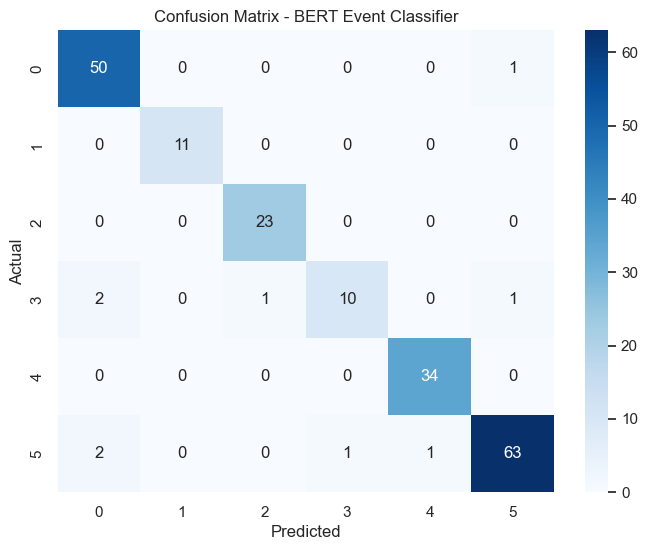

In [ ]:
########### BERT


### set all reproducibility, though minor divergences possible due to change of environment
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)



### label encode target - prepares labels from event_type for multiclass classification
df = df.copy()
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['event_type'])
num_labels = df['label'].nunique()


### create Hugging Face dataset - enables integration with Hugging Face's Trainer API, transformers
dataset = Dataset.from_pandas(df[['notes', 'label']])
dataset = dataset.train_test_split(test_size=0.2, seed=42)


### load tokenizer from Hugging Face and tokenize
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(example):
    return tokenizer(example["notes"], padding="max_length", truncation=True)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.remove_columns(["notes"])
dataset.set_format("torch")



### load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)


### define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


### define training arguments
training_args = TrainingArguments(
    output_dir="./bert-event-classifier",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    seed=42,
    logging_strategy="epoch")


### define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)


### train and evaluate
trainer.train()
results = trainer.evaluate()


### print metrics
print("\nFinal Evaluation Metrics:")
for key, value in results.items():
    if key.startswith("eval_"):
        print(f"{key[5:]}: {value:.4f}")


### define confusion matrix plot function and run it
def plot_confusion_matrix():
    y_preds = np.argmax(trainer.predict(dataset["test"]).predictions, axis=1)
    y_true = dataset["test"]["label"]
    cm = pd.crosstab(pd.Series(y_true, name='Actual'),
                     pd.Series(y_preds, name='Predicted'),
                     rownames=['Actual'], colnames=['Predicted'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix - BERT Event Classifier")
    plt.show()

plot_confusion_matrix()

/Users/namigabbasov/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]


Final Evaluation Metrics:
loss: 0.2024
accuracy: 0.9650
f1: 0.9608
precision: 0.9633
recall: 0.9613
runtime: 5.0683
samples_per_second: 39.4610
steps_per_second: 2.5650


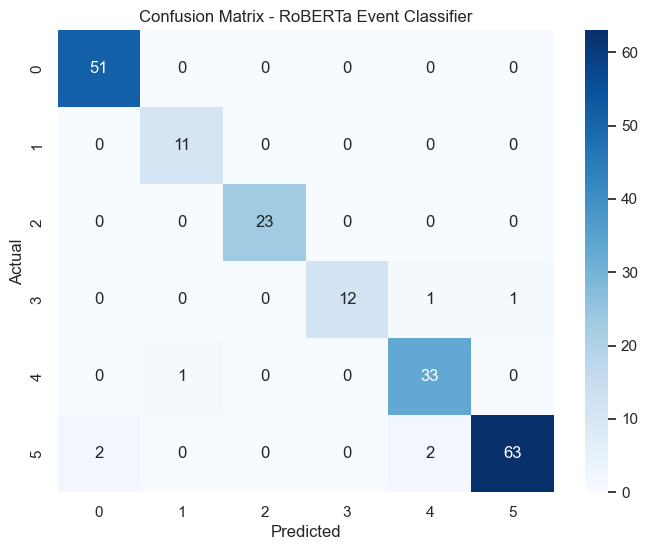

In [ ]:
##############RoBERTa


### set all reproducibility, though minor divergences possible due to change of environment
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


### encode your labels
df = df.copy()
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['event_type'])  ### convert event_type to numeric
num_labels = df['label'].nunique()


### create Hugging Face dataset with fixed split
dataset = Dataset.from_pandas(df[['notes', 'label']])
dataset = dataset.train_test_split(test_size=0.2, seed=42)


### load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)


### tokenize dataset - max_length in roberta is 512 tokens
def tokenize(example):
    return tokenizer(example["notes"], padding="max_length", truncation=True)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.remove_columns(["notes"])
dataset.set_format("torch")


### define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall}


### define training arguments
training_args = TrainingArguments(
    output_dir="./roberta-event-classifier",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=42,
    logging_strategy="epoch")


### trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)


### train and evaluate
trainer.train()
eval_results = trainer.evaluate()


### print final evaluation results
print("\nFinal Evaluation Metrics:")
for k, v in eval_results.items():
    if k.startswith("eval_"):
        print(f"{k[5:]}: {v:.4f}")

### make function for confusion matrix
def plot_confusion_matrix():
    y_preds = np.argmax(trainer.predict(dataset["test"]).predictions, axis=1)
    y_true = dataset["test"]["label"]
    cm = pd.crosstab(pd.Series(y_true, name='Actual'),
                     pd.Series(y_preds, name='Predicted'),
                     rownames=['Actual'], colnames=['Predicted'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix - RoBERTa Event Classifier")
    plt.show()

plot_confusion_matrix()

## <center> **Question III:Multilingual Agentic RAG System for News Event Comparison**



## Objective

Design multilingual Retrieval-Augmented Generation system enhanced with agentic reasoning to:

- Detect overlapping news stories reported in multiple languages and from different sources.
- Identify unique news articles.
- Summarize events and highlight differences in coverage like framing, actors, locations etc

This system builds multilingual, intelligent event comparison tool capable of:

- Reasoning across languages
- Understanding semantic similarity
- Comparing narratives across sources
- scalable, modular, and can support both cloud-based and local setups

---

## System Overview

Below is core of the system. It can be empowered by other additions such consine similarity, NER and various NPL tools/techniques could be integrated.


### Collect and Normalize Articles

- Collect data from various sources: news APIs, databases, PDFs, CSVs, web-scraped articles, etc.
- Each article should have at least these core fields:
    - id: Unique identifier for article
    - title: Title or headline of news article
    - text: full article content
    - source: media outlet or platform it came from
    - language: language code or name
    - date: publication date
- normalize text and remove boilerplate such journalist names, ads, etc.

---

### Translate to Primary Language

While preserving both original and translated versions for transparency, use one of high-quality machine translation models. if there is suffcient resources and time, I would try all three. If not, I would go directly with first one. It is free via Hugging Face.
  - `facebook/nllb-200` - no language left behind
  - `m2m100` - is free too.
  - Google Translate or DeepL API - commercial API but easy to use.


---

### Generate Embeddings

Use one of multilingual embedding model below to vectorize translated article text. These embeddings are essential for retrieving similar articles and comparing them across languages. These embeddings will represent semantic content of news articles.

- `sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2` - fast inference
- `LaBSE` - robust and multilingual quality


---

### Store Embeddings in Pinecone
- I have experience using Pinecone,so I will go with it for storing embeddings.
- Metadata will include language, source, date, and region.
- This enables fast semantic search across languages.

---

### Retrieve Similar Articles with Pinecone

- For each new article, retrieve top-k similar articles using cosine similarity of embeddings
- Add temporal filter like ±2 days to constrain search to likely event matches.
- This step narrows down potential matches efficiently.

---

### LLM-Based Comparison

Use LLM API(I would prefer GPT-4) to:
- Compare article to retrieved articles.
- Judge whether they describe same event
- If yes: summarize shared event and highlight differences.
- If no: explain why (e.g. different time, actors, or location).

---

### Post-Processing and Output

Based on LLM responses:
- Group overlapping articles into clusters
- Label singletons as unique articles
- Visualize clusters using t-SNE or UMAP: Each point = one article, Clusters = same event, Outliers = unique stories

---


## Components Summary



| Task                      | Tool                                                  |
|---------------------------|-------------------------------------------------------|
| Translation               | `nllb-200`, `m2m100`, Google Translate API            |
| Embedding                 | `paraphrase-multilingual-MiniLM`, `LaBSE`             |
| Vector Storage            | Pinecone                                              |
| Retrieval Framework       | Pinecone SDK                                          |
| LLM Comparison Agent      |`gpt-4o` via API                                       |


## Prompt Example

You are multilingual news analyst.Given a new article and a retrieved article, answer:
1. Do these two texts describe the same event? (YES/NO)
2. If YES, summarize the event and highlight differences in how each source reports it.
3. If NO, explain why not (e.g., different location, time, actors, outcomes).

{"article_1": "...",
  "article_2": "...",
  "prompt": "Do these articles describe the same event? YES/NO and why."}

{"match": "YES",
  "summary": "Protest in Bamako on March 3, 2024, involving opposition groups.",
  "differences": "Article 1 focuses on police violence; Article 2 emphasizes political motives."}

In [ ]:
end_time = time.time()
total_time = end_time - start_time
mins, secs = divmod(total_time, 60)
print(f"\nTotal notebook runtime: {int(mins)} minutes and {int(secs)} seconds ({total_time:.2f} seconds)")


Total notebook runtime: 13 minutes and 13 seconds (793.37 seconds)
